In [1]:
from multiprocessing import Pool
import os
os.environ['OMP_NUM_THREADS'] = "1"

import numpy as np

import astropy.units as u  
import astropy.constants as c
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib 

from astropy.io import fits
from astropy.table import Table, join
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from dustmaps.bayestar import BayestarQuery
from dustmaps.vergely2022 import Vergely2022Query
from dustmaps.edenhofer2023 import Edenhofer2023Query

import pickle 
import sys
import os
import tqdm

import emcee
import corner

import h5py

/uufs/astro.utah.edu/common/home/u1371365/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
import globalvars
dust_data = globalvars.DustData()

In [3]:
from sightline import Sightline
from specfns import get_wavs, resample_interp, dopplershift, lambda0, sigma0
from filehandling import get_ca_res, get_madgics_res
from spacefns_v2 import select_stars, find_nearest, find_radius, differentialAmplitude
from MCMCfns import logprob_2
import time

# import globalvars
# dust_data = globalvars.DustData()
# with h5py.File(map_fname, 'r') as f:
#     edenhofer = np.array(f['data'])
#     dust_data.intake_map(edenhofer)

In [4]:
map_fname = '/uufs/astro.utah.edu/common/home/u1371365/DIB_KT_CACloud/edenhofer_out.h5'

with h5py.File(map_fname, 'r') as f:
    edenhofer = np.array(f['data'])
    dust_data.intake_map(edenhofer)

/scratch/local/u1371365/1244903/ipykernel_7004/2315330892.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  edenhofer = np.array(f['data'])


In [5]:
CA_meta = Table(fits.open('../Data/230420_CAResiduals/CA_meta.fits')[1].data)
CAresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230420_CAResiduals/'
CAMADGICSresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230829_MADGICSResiduals/'
starhorsepath = '/uufs/chpc.utah.edu/common/home/sdss/dr17/env/APOGEE_STARHORSE/APOGEE_DR17_EDR3_STARHORSE_v2.fits'
starhorse = Table.read(starhorsepath, hdu = 1)
starhorse = starhorse['APOGEE_ID', 'dist16', 'dist50', 'dist84', 'AV16', 'AV50', 'AV84']

CA_meta = join(CA_meta, starhorse, keys = 'APOGEE_ID', join_type = 'left')

CA_meta_full = CA_meta.copy()

with open('/uufs/astro.utah.edu/common/home/u1371365/DIB_KT_CACloud/goodbad.pickle', mode = 'rb') as f:
    goodbad = pickle.load(f)

# added 02.01
data_criteria = (((CA_meta['SNR'] > 80) & (CA_meta['TEFF'] > 5000)) | (CA_meta['SNR'] > 150)) & (CA_meta['ASPCAP_CHI2_1'] > 1) & (CA_meta['ASPCAP_CHI2_1'] < 5)
print(np.sum(data_criteria))
CA_meta= CA_meta[data_criteria]

1010


In [6]:
wavs = get_wavs()
window = (wavs > lambda0 -10) & (wavs < lambda0 + 10)
wavs_window = wavs[window]

In [7]:
# sample_dim_l[0] - sample_dim_l[1]

In [8]:
ds = 2.5 # x downsampled
rad = 0.23
sample_dim_l = np.linspace(159, 167, int(8 / (ds * rad)))
sample_dim_b = np.linspace(-12.5 , -4.5, int(8 / (ds * rad)))
sample_grid_l, sample_grid_b = np.meshgrid(sample_dim_l, sample_dim_b)
grid_map_inds = np.array([find_nearest(sample_grid_l.flatten()[i], sample_grid_b.flatten()[i]) for i in range(len(sample_grid_l.flatten()))]).T
grid_map = np.nansum(np.copy(edenhofer[grid_map_inds[1], grid_map_inds[0], :]).reshape(*sample_grid_l.shape, -1), axis = 2)
grid_Nstar = np.array([np.nansum((np.abs((sample_grid_l.flatten()[i] - CA_meta['GLON'])) <= rad) & 
            (np.abs((sample_grid_b.flatten()[i] - CA_meta['GLAT'])) <= rad)) for i in range(len(sample_grid_l.flatten()))]).reshape(*sample_grid_l.shape)

filament_l = (159, 169)
filament_b = (-10, -6)

N_min = 5
radius_min = np.zeros(sample_grid_l.shape)
mgrid = np.mgrid[0:len(sample_dim_l), 0:len(sample_dim_b)]
for i in mgrid[0].flatten():
    for j in mgrid[1].flatten():
        radius_min[i, j] = find_radius(sample_grid_l[i, j], sample_grid_b[i, j], N_min, CA_meta)
        radius_min[i, j] = np.max([radius_min[i, j], 0.23])

radius_max = 0.4
print(np.nansum(radius_min < radius_max))


crit_filament = ((sample_grid_l > filament_l[0]) & (sample_grid_l < filament_l[1]) & 
                 (sample_grid_b > filament_b[0]) & (sample_grid_b < filament_b[1]) &
                 (grid_map > 2.2) & (radius_min < 0.5)) #(grid_Nstar > 5) & (grid_Nstar <= 10))

crit_background =  (((sample_grid_l <= filament_l[0]) | (sample_grid_l >= filament_l[1]) |
                 (sample_grid_b <= filament_b[0]) | (sample_grid_b >= filament_b[1])) &
                 (grid_map <= 1.5) & (radius_min < radius_max)) #(grid_Nstar > 5) & (grid_Nstar <= 10))

# crit_coverage = (np.sum() => 1 & )

N_filament = np.sum(crit_filament)
N_background = np.sum(crit_background)
print(np.sum(crit_filament))
print(np.sum(crit_background))

91
23
28


In [9]:
l_fil, b_fil, AV_fil = (sample_grid_l[crit_filament].flatten(), sample_grid_b[crit_filament].flatten(),
                        grid_map[crit_filament].flatten())
l_off, b_off, AV_off = (sample_grid_l[crit_background].flatten(), sample_grid_b[crit_background].flatten(),
                        grid_map[crit_background].flatten())

l_sample, b_sample, AV_sample = (np.concatenate([l_fil, l_off]), np.concatenate([b_fil, b_off]),
                                  np.concatenate([AV_fil, AV_off]))

In [10]:
tabfile = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStar-dr17-synspec_rev1.fits'
allStar = Table.read(tabfile, hdu = 1)
print(len(allStar))
starFlag = allStar['ASPCAPFLAG']
starMask = np.invert((np.logical_and(starFlag, 2**23)==True))
allStar = allStar[starMask]
print(len(allStar))
highLat = allStar[(np.abs(allStar['GLAT']) > 15) & (1000/allStar['GAIAEDR3_PARALLAX'] < 1.5e3) & (allStar['SFD_EBV'] < 0.2)]

data_criteria_hl= (((highLat['SNR'] > 80) & (highLat['TEFF'] > 5000)) | (highLat['SNR'] > 150)) & (highLat['ASPCAP_CHI2'] > 1) & (highLat['ASPCAP_CHI2'] < 5)
print(sum(data_criteria_hl))

print(len(highLat))
highLat = highLat[data_criteria_hl]

733901
348087
45661
74255


In [11]:
133 & 2**23

0

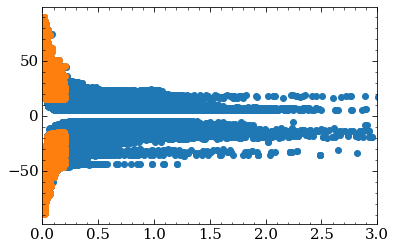

In [12]:
fig, ax = plt.subplots()
ax.scatter(allStar['SFD_EBV'], allStar['GLAT'])
ax.set_xlim(0, 3)
ax.scatter(highLat['SFD_EBV'], highLat['GLAT'])


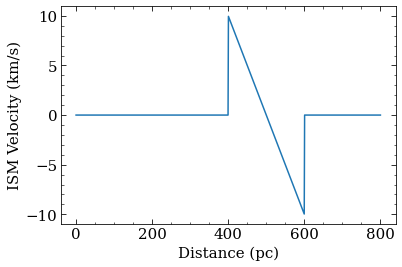

Text(0, 0.5, 'dA(V)/dd')

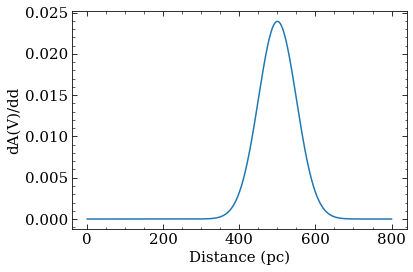

In [13]:
fig, ax = plt.subplots()
cloudmin, cloudmax = (400, 600)
nearvelo, farvelo = (+10, -10)
rvelo = (farvelo - nearvelo) / (cloudmax - cloudmin) * (dust_data.distance - cloudmin) - farvelo
rvelo[(dust_data.distance < cloudmin) | (dust_data.distance > cloudmax)] = 0
ax.plot(dust_data.distance, rvelo)
ax.set_xlabel('Distance (pc)')
ax.set_ylabel('ISM Velocity (km/s)')
plt.show()

cloudcen = 0.5 * (cloudmin + cloudmax)
d0 = 400            # Cloud center
w0 = 50             # Cloud width (stdev)
Av_max = 3          # Maximum extinction

def differentialAV(d, d0 = cloudcen, w0 = w0, Av_Max = Av_max):
    A = Av_max / (np.sqrt(2 * np.pi) * w0) 
    return A * np.exp(-(d - d0)**2 / (2 * w0**2))

diff_AV = differentialAV(dust_data.distance)

fig, ax = plt.subplots()
ax.plot(dust_data.distance, diff_AV)
ax.set_xlabel('Distance (pc)')
ax.set_ylabel('dA(V)/dd')

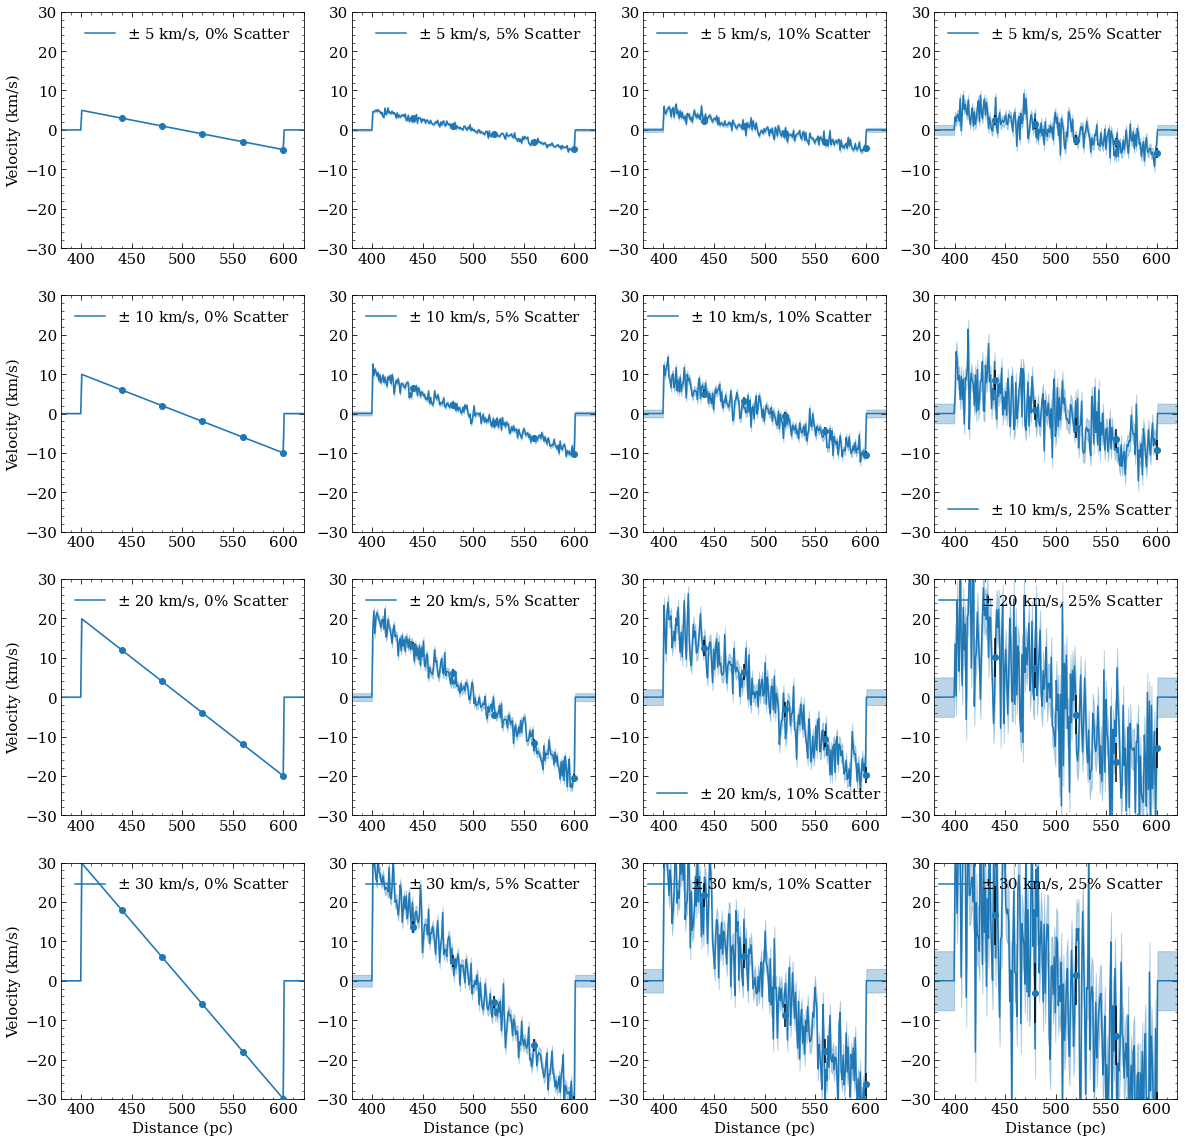

In [15]:
velocity_range = [5, 10, 30]# 
velocity_range = [5, 10, 20, 30]
scale_range = [0, 10, 25]# 
scale_range = [0, 5, 10, 25]
fig, axs = plt.subplots(nrows = len(velocity_range), ncols = len(scale_range), figsize = (20, 20))
def velo_profile(half_v_range, scale = 0):
    cloudmin, cloudmax = (400, 600)
    nearvelo, farvelo = (+half_v_range, -half_v_range)
    rvelo = (farvelo - nearvelo) / (cloudmax - cloudmin) * (dust_data.distance - cloudmin) - farvelo
    rvelo = rvelo + np.random.normal(0, 2 * scale/100 * half_v_range, len(rvelo))
    rvelo[(dust_data.distance < cloudmin) | (dust_data.distance > cloudmax)] = 0
    star_locs = np.linspace(440, 600, 5)
    star_loc_rvelo = (farvelo - nearvelo) / (cloudmax - cloudmin) * (star_locs - cloudmin) - farvelo
    star_loc_rvelo_scattered = star_loc_rvelo + np.random.normal(0, scale/100 * half_v_range, len(star_locs))
    
    return rvelo, star_loc_rvelo_scattered, star_locs


for i in range(len(velocity_range)):
    for j in range(len(scale_range)):
        ax = axs[i, j]
        rvelo, star_loc_rvelo_scattered, star_locs = velo_profile(velocity_range[i], scale_range[j])
        ax.plot(dust_data.distance, rvelo, label = f'$\pm$ {velocity_range[i]} km/s, {scale_range[j]}% Scatter')
        ax.scatter(star_locs, star_loc_rvelo_scattered, zorder = 3)
        ax.fill_between(dust_data.distance, 2 * rvelo + scale_range[j]/100 * velocity_range[i], 2 rvelo - scale_range[j]/100 * velocity_range[i], alpha = 0.3, color = 'C0')
        ax.errorbar(star_locs, star_loc_rvelo_scattered, yerr = scale_range[j]/100 * velocity_range[i], fmt = '.', zorder = 2, color = 'k')
        ax.legend()
        if i == len(velocity_range) - 1:
            ax.set_xlabel('Distance (pc)')
        if j == 0:
            ax.set_ylabel('Velocity (km/s)')
        ax.set_xlim(380, 620)
        ax.set_ylim(-np.max(velocity_range), np.max(velocity_range))
fig.set_facecolor('white')
plt.show()

In [ ]:
dibfn = lambda x, mu, sigma, a: 1-a * np.exp(-0.5 * (x - mu)**2 / sigma**2)
def sigma_clip_mask(y, x = wavs, k = 2.5):
    y_over_gauss = None

    try:
        gaussfit = curve_fit(dibfn, x[window], y[window].filled(np.nan), p0 = (15272, 1.2, 0.05), bounds = ([15269, 0.5, 0], [15275, 2, 0.15]), check_finite = False, nan_policy = 'omit')

    except:
        # gaussfit = ((15272, 1.2, 0.05),())
        print('fail')
        return None, None
    #     y_over_gauss = None
    #     gaussfit = ((15272, 1.2, 0.05),())
    #     # fit = dibfn(x, 15272.42, 1.2, 0.05)
    #     # y_over_gauss = y / fit
    #     print('POOR GAUSS FIT IN SIGMA CLIP')
    y_over_gauss = y / dibfn(x, *gaussfit[0])

    med = np.nanmedian(y_over_gauss[window])
    stdev = np.std(y_over_gauss[window], ddof = 1)
    mask = np.abs(y_over_gauss - med) > k * stdev
    mask = mask + np.roll(mask, -1) + np.roll(mask, -1)
    mask = mask.astype(bool)
    return mask, stdev

def sigmaClip(y, yerr,k=2.5):
    clip = True
    clip_iters = 0
    std = np.nanstd(y[window], ddof = 1)
    mask = np.zeros(y.shape).astype(bool)
    clip_success = True

    while clip:
        clip_mask, std_clipped = sigma_clip_mask(np.ma.array(y, mask = mask.copy()), k = k)
        if clip_mask is None:
            clip_success = False
            return mask, clip_success
        clip_mask = clip_mask.filled(False)

        if std - std_clipped  < 1e-4:
            clip = False


        else:
            clip_iters += 1
            std = std_clipped
            mask = mask + clip_mask

    return mask, clip_success

def generateClippedResidual(aspcap, medres, apstar, rv, k = 3):
    spectrum = aspcap[1].data
    model = aspcap[3].data
    err = aspcap[2].data
    bitmask = apstar[3].data[0, :]

    if medres[1].data is None:
        medres_model = np.ones(spectrum.shape)
        medres_err =np.zeros(spectrum.shape)
    else:
        medres_model = np.array(medres[1].data)
        medres_err = np.array(medres[3].data)



    mask_digits = [0, 1, 2, 9, 12, 13] # 0 BADPIX, 1 CRPIX, 2 SATPIX, 9 PERSIST_HIGH, 12 SIG_SKYLINE, 13 SIG_TELLURIC
    mask = np.zeros(bitmask.shape)
    for digit in mask_digits:
        mask = mask + np.bitwise_and(bitmask.astype(int), 2**digit) 

    mask = mask.astype(bool)
    res_corr = spectrum / model / medres_model
    # print('res corr shape', res_corr.shape)
    uncertainty_corr = np.sqrt(err**2) #+ medres_err**2)

    sky_residuals = [(15268.1, 1),(15274.1, 1),(15275.9, 1)]
    manual_masks = np.zeros(len(wavs))
    for sky in sky_residuals:
        wl = sky[0]
        manual_masks[np.argmin(np.abs(wavs - wl))] = True
    manual_masks = manual_masks + np.roll(manual_masks, -1) + np.roll(manual_masks, 1)

    # mask_sigmaclip = np.zeros(len(wavs))


    maskSigClip, clip_success = sigmaClip(res_corr, uncertainty_corr, k = k)

    mask = mask + maskSigClip
    mask = mask.astype(bool)

    res_corr_ma = np.ma.array(res_corr, mask = mask)
    res_corr_filled = res_corr_ma.filled(np.nan)

    res_corr_resamp = resample_interp(res_corr_filled, rv)
    uncertainty_corr_resamp = resample_interp(uncertainty_corr, rv)

    sky_residuals = [(15268.1, 1),(15274.1, 1),(15275.9, 1)]
    manual_masks = np.zeros(len(wavs))
    for sky in sky_residuals:
        wl = sky[0]
        manual_masks[np.argmin(np.abs(wavs - wl))] = True
    manual_masks = manual_masks + np.roll(manual_masks, -1) + np.roll(manual_masks, 1)


    res_corr_resamp = np.ma.array(res_corr_resamp, mask = manual_masks)
    res_corr_resamp = res_corr_resamp.filled(np.nan)


    return res_corr_resamp, uncertainty_corr_resamp#, clip_success

In [ ]:
# from residual_process import reprocess
from spacefns_v2 import find_nearest, find_nearest_dist
from filehandling import get_medres, getASPCAP, getapStar
from residual_process import generateResidual

class InjectionSightline(Sightline):
    def __init__(self, stars, rvelo, dAVdd = None, injectRealContinuum = True, bins = None, **kwargs):
        super().__init__(stars, **kwargs)
        self.actual_DIBs = np.copy(self.signals)
        self.actual_DIB_errs = np.copy(self.signal_errs)
        self.makeSyntheticDIBs(rvelo, dAVdd = dAVdd, injectRealContinuum = injectRealContinuum)

    def makeSyntheticDIBs(self, rvelo, dAVdd = None, injectRealContinuum = True):
        continua = np.zeros(self.signals.shape)
        continua_errs = np.zeros(self.signals.shape)
        dustcolumn = np.zeros((len(self.stars), dust_data.dustmap.shape[-1]))
        for i in range(len(self.stars)):
            star = self.stars[i]
            rv_star = star['VHELIO_AVG']
            if injectRealContinuum:
                continuum, continuum_uncertainty = self.getAnalogContinuum(star, rv_star)
                continua[i, :] = continuum[window]
                continua_errs[i, :] = continuum_uncertainty[window]
            else:
                continuum = 1 + np.random.normal(scale = 1/star['SNR'], size = np.sum(window))
                continuum_uncertainty = np.ones(np.sum(window)) * 1/star['SNR']
                continua[i, :] = continuum
                continua_errs[i, :] = continuum_uncertainty

            l_i, b_i = find_nearest(star['GLON'], star['GLAT'])
            d_i = find_nearest_dist(star['DIST']).item()
            if dAVdd is not None:
                dcol = np.copy(dAVdd)
                dcol[d_i:] = 0
            else:
                dcol = dust_data.dustmap[b_i, l_i, :]
                dcol[d_i:] = 0
            dustcolumn[i, :] = dcol

                

        raw_DIB = self.integrateMockDIB(rvelo, dustcolumn)
        signals = raw_DIB - 1 + continua

        self.signals = signals
        self.signal_errs = continua_errs
        self.raw_DIB = raw_DIB
        self.continuum = continua
        self.dustcolumn = dustcolumn

    def getAnalogContinuum(self, star, rv_star, reference_stars = highLat):
            SNRdiff = np.abs(reference_stars['SNR'] - star['SNR'])
            TEFFdiff = np.abs(reference_stars['TEFF'] - star['TEFF'])
            LOGGdiff = np.abs(reference_stars['LOGG'] - star['LOGG'])
            M_Hdiff = np.abs(reference_stars['M_H'] - star['M_H'])
            starAnalogs = np.logical_and.reduce([(SNRdiff < 30), (TEFFdiff < 250), (LOGGdiff < 0.2), (M_Hdiff < 0.1)]) 
            analog_i = np.argmin(reference_stars[starAnalogs]['SFD_EBV'])
            analog = reference_stars[analog_i]
            medres = fits.open(get_medres(analog['TEFF'], analog['LOGG'], analog['M_H']))
            aspcap = fits.open(getASPCAP(analog))
            apstar = fits.open(getapStar(aspcap))
            res, res_err = generateClippedResidual(aspcap, medres, apstar, rv_star)
            return res, res_err
            
    def integrateMockDIB(self, rvelo, dAVdd):
        print(rvelo.shape)
        print(dAVdd.shape)
        signals = np.zeros((len(self.stars), len(wavs_window)))
        peak_wavelength = dopplershift(rvelo)
        wavs_grid = np.tile(wavs_window, (len(rvelo), 1))
        print(wavs_grid.shape)
        voxel_DIB_unscaled = np.exp(-(wavs_grid - peak_wavelength[:, np.newaxis])**2 / (2 * sigma0**2))
        amp = differentialAmplitude(dAVdd, 1)

        def single_signal(amp, bindex):
            # amp[bindex :] = 0 # THIS MIGHT NEED TO BE -1

            voxel_DIB_scaled = -voxel_DIB_unscaled *  amp[:, np.newaxis] 
            summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
            # continuum = lambda x, m, b : m * (x - lambda0) + b
            # cont = continuum(wavs_window, 0, b)
            return summed_DIB  + 1


        for i in range(len(self.stars)):
            star = self.stars[i]
            dAVdd_star = dAVdd[i, :]
            amp = differentialAmplitude(dAVdd_star, 1)

            bin_index = self.bin_inds[i]
            # signals[i, :] = single_signal(bin_index)
            signals[i, :] = single_signal(amp, 0)# bin_index)
        return signals



In [ ]:
radius_min_fil = radius_min[crit_filament].flatten()
radius_min_off = radius_min[crit_background].flatten()
radius_sample = np.concatenate([radius_min_fil, radius_min_off])

selected_inds = []
for i in range(len(l_sample)):
    l_center, b_center = l_sample[i], b_sample[i]
    rad_i = radius_sample[i]
    selection = select_stars(CA_meta, l_center, b_center, radius = rad_i)
    print(len(selection))
    selected_inds.append(selection)

5
5
5
5
5
5
5
5
5
5
7
5
5
5
5
5
5
7
6
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
14
5
5
6
5
5
5
5
6
5
5
5
5
5
5
6


In [ ]:

if False: 
    fig, ax = plt.subplots(figsize = (6,6))

    im = ax.imshow(np.nansum(dust_data.dustmap, axis = 2), origin = 'lower', cmap = 'binary', extent = (dust_data.l0-9, dust_data.l0+9, dust_data.b0-9, dust_data.b0+9))
    ax.set_xlabel('l (deg)')
    ax.set_ylabel('b (deg)')
        
    ax.scatter(l_sample[i], b_sample[i],  color = 'C0')


    cax0 = ax.inset_axes([dust_data.l0-10,dust_data.b0-9 , 1, 18], transform =ax.transData)

    fig.colorbar(im, ax = ax, cax = cax0, label = '$A_V$')
    xmin, xmax = ax.get_xlim()
    # ax.legend(loc = 'upper left')
    ax.set_xlim(xmax, xmin)

    plt.show()

In [ ]:
sightlines = []
for i in range(len(velocity_range)):
    for j in range(len(scale_range)):    
        indx = selected_inds[0] 
        vrange, scale = velocity_range[i], scale_range[j]
        rvelo, star_loc_rvelo_scattered, star_locs = velo_profile(vrange, scale = scale)
        sightlines.append(InjectionSightline(CA_meta[indx], rvelo = rvelo, dAVdd = diff_AV, injectRealContinuum = True , dustdata = dust_data))
        sightlines[i].intake_coords(l_sample, b_sample, AV = AV_sample)

/uufs/astro.utah.edu/common/home/u1371365/nanoKT_v1/residual_process.py:7: RuntimeWarning: invalid value encountered in divide
  res = hdu_rf[0, :] / hdu_rf[2, :]
/tmp/ipykernel_1214535/2757415826.py:72: RuntimeWarning: invalid value encountered in divide
  res_corr = spectrum / model / medres_model
/uufs/astro.utah.edu/common/home/u1371365/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


(800,)
(5, 800)
(800, 95)
(800,)
(5, 800)
(800, 95)
(800,)
(5, 800)
(800, 95)
(800,)
(5, 800)
(800, 95)
(800,)
(5, 800)
(800, 95)
(800,)
(5, 800)
(800, 95)
(800,)
(5, 800)
(800, 95)
(800,)
(5, 800)
(800, 95)
(800,)
(5, 800)
(800, 95)


In [ ]:
# fig, ax = plt.subplots()
# for i in range(len(sightlines)):
#     ax.scatter(sightlines[i].bins, i*np.ones(len(sightlines[i].bins) ))
# ax.set_xlim(300, 700)
# plt.show()

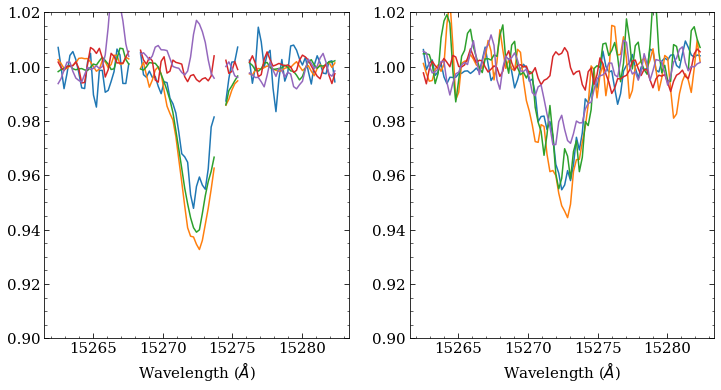

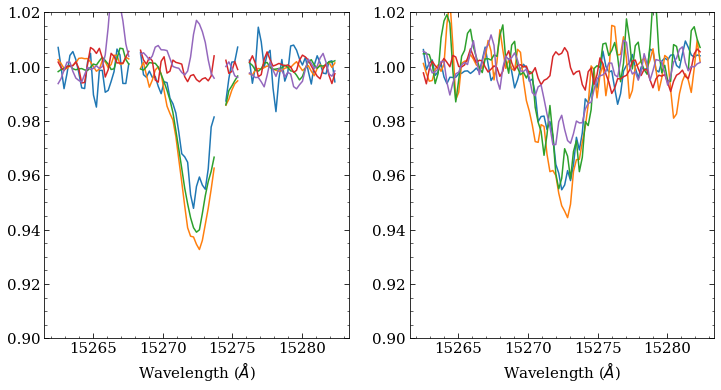

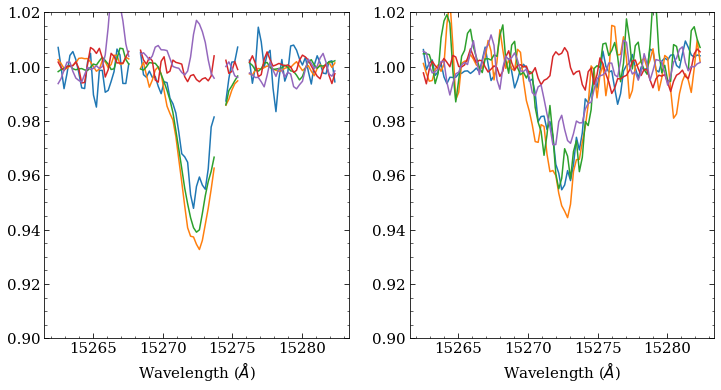

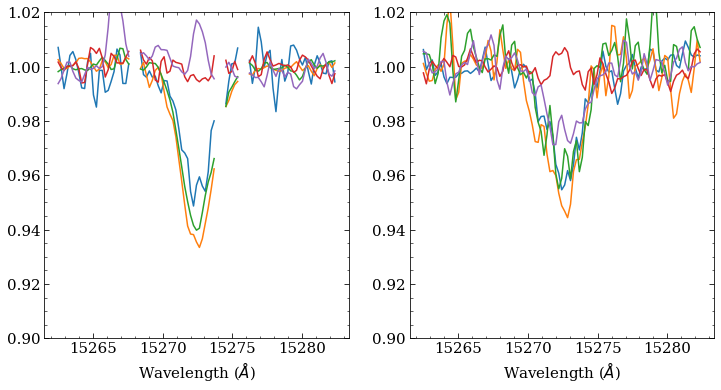

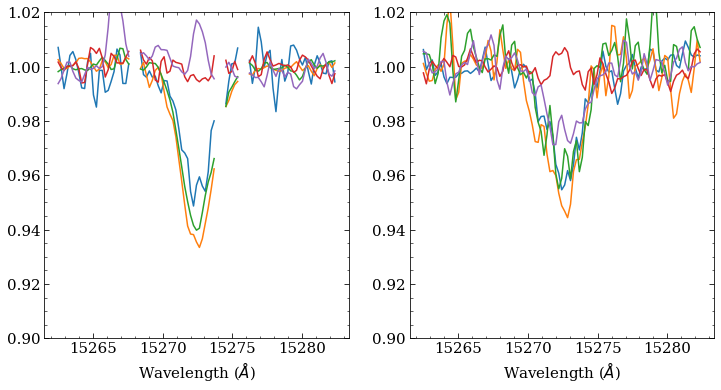

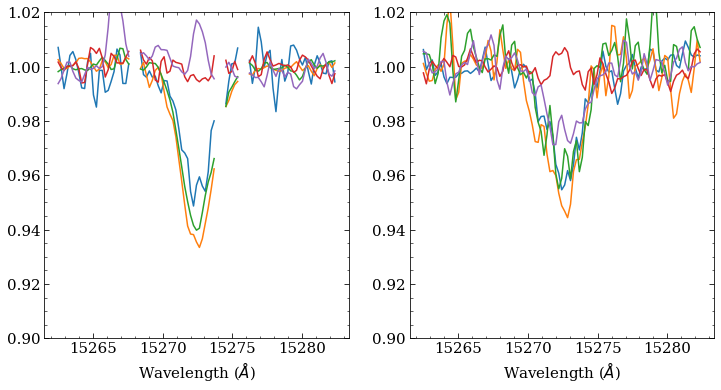

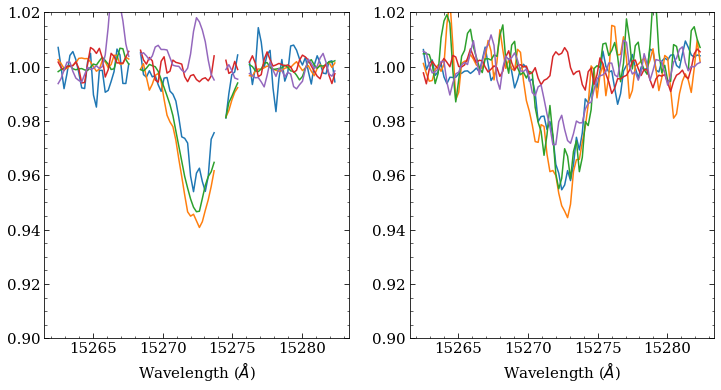

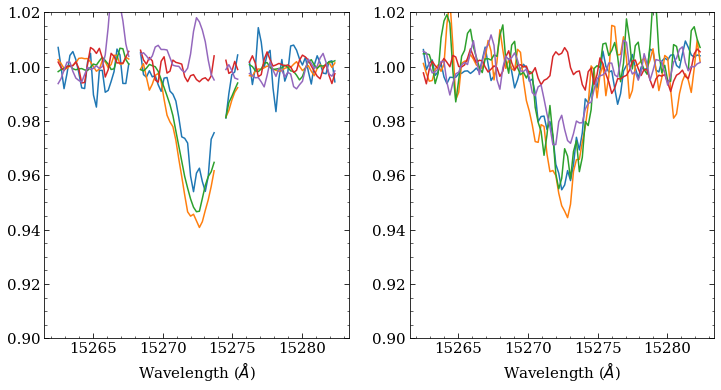

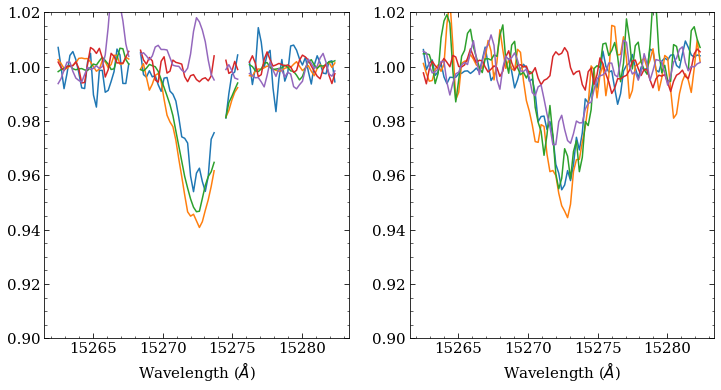

In [ ]:
for i in range(len(sightlines)):
    sl = sightlines[i]
    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))
    ax = axs[0]
    for j in range(len(sl.signals)):
        ax.plot(wavs_window, sl.signals[j, :])
        ax.set_ylim(0.9, 1.02)
        ax.set_xlabel(r'Wavelength ($\AA$)')
    ax = axs[1]
    for j in range(len(sl.actual_DIBs)):
        ax.plot(wavs_window, sl.actual_DIBs[j, :])
        ax.set_ylim(0.9, 1.02)
        ax.set_xlabel(r'Wavelength ($\AA$)')
    plt.show()

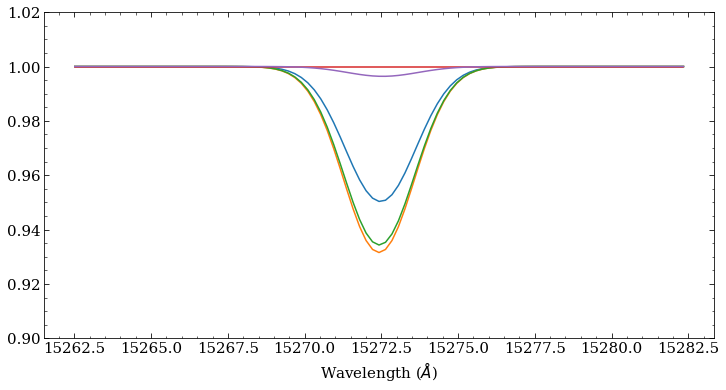

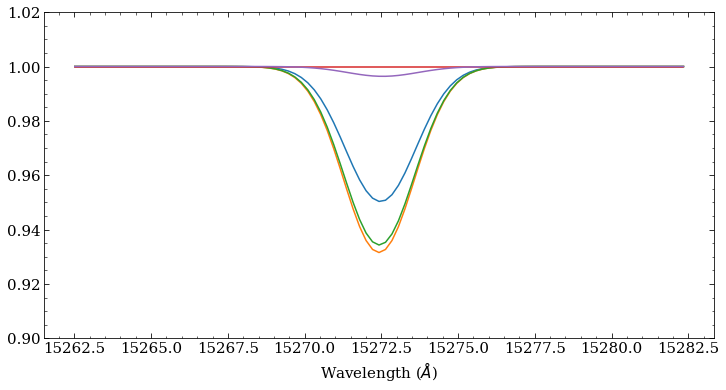

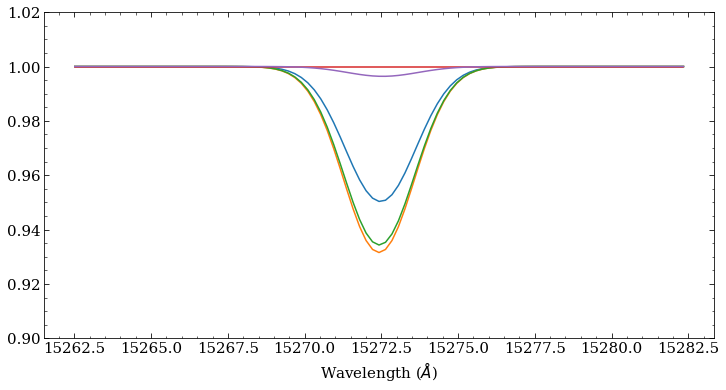

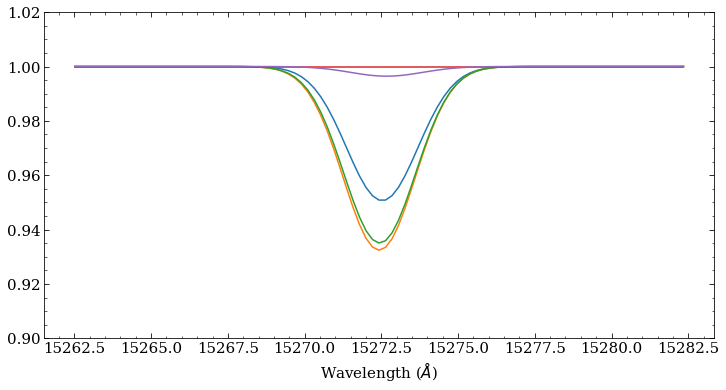

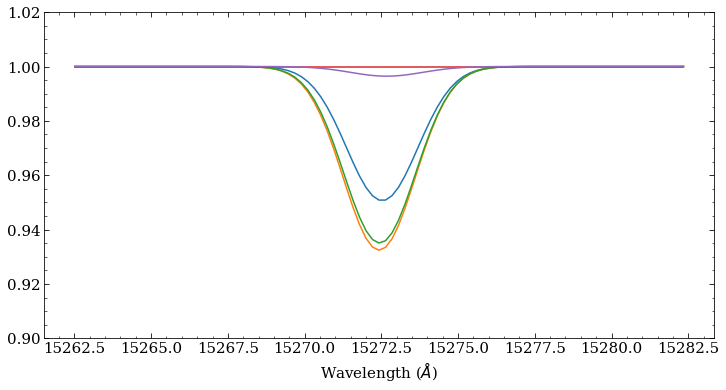

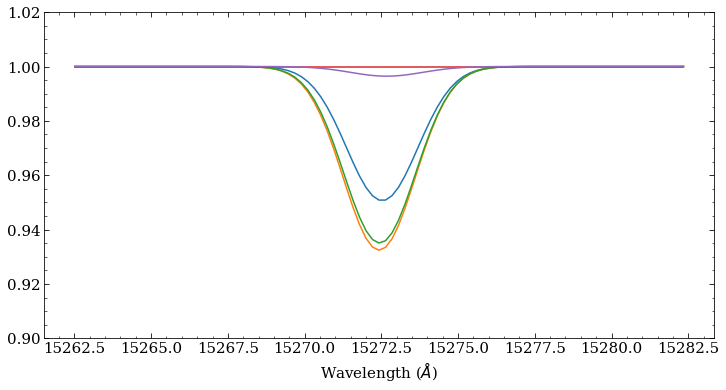

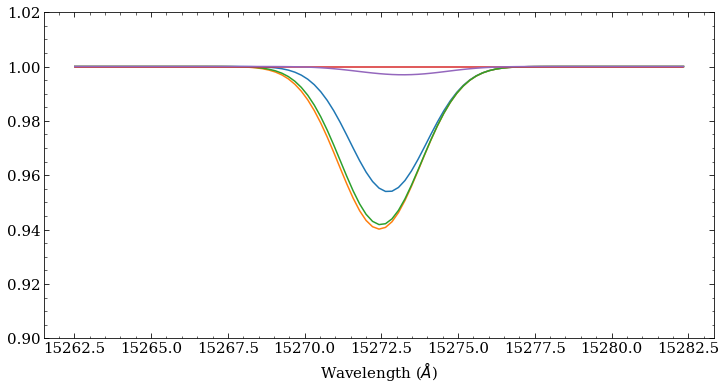

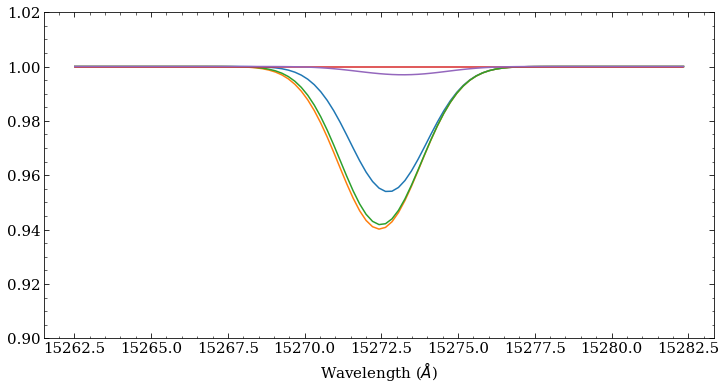

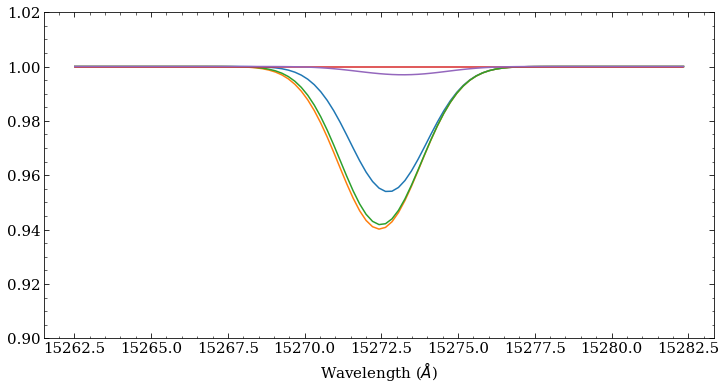

In [ ]:
for i in range(len(sightlines)):
    sl = sightlines[i]
    fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
    for j in range(len(sl.signals)):
        ax.plot(wavs_window, sl.raw_DIB[j, :] )
        ax.set_ylim(0.9, 1.02)
        ax.set_xlabel(r'Wavelength ($\AA$)')

In [ ]:
sl.raw_DIB.shape

(5, 95)

In [ ]:
from MCMCfns import logprob_2

In [ ]:
farvelo

-10

In [ ]:
def logprior_v_mod(v, vmin = 1.2 * farvelo, vmax = 1.2 * nearvelo, **kwargs):
    if np.any(v > 100) or np.any(v < 100):
        return - np.inf
    return 0.0



In [ ]:
def MCMC_scary_mod(sl, steps = 1000, nwalkers = 100, pool = None, filename =None):
    ndim = len(sl.voxel_dAVdd) 
    nstar = len(sl.stars)
    ndim_amp = int(ndim + ndim * nstar)
    

    # dAVdd_prior = sl.dAVdd[:]
    # dAVdd_prior[dAVdd_prior == 0] = np.nan 
    # dAVdd_prior_med = np.nanmedian(dAVdd_prior, axis = 1)
    # dAVdd_prior_std = np.nanstd(dAVdd_prior, axis = 1, ddof = 1)
    # gaussparams = (dAVdd_prior_med, dAVdd_prior_std)
    # print(gaussparams)


    if filename is not None:
        backend = emcee.backends.HDFBackend(filename)
        backend.reset(nwalkers, ndim_amp)
    else:
        backend = None
    # with Pool(15) as pool:

    sampler = emcee.EnsembleSampler(nwalkers, ndim_amp , logprob_2, 
                                    kwargs={'sl': sl, 'logprior': logprior_v_mod, 'prior_mult':  1, 'v_max': 20, 'sigma': None}, pool = pool)
    # init = 12.5 *(np.random.random((nwalkers, ndim_amp)) - 0.5)
    init = 10 * (np.random.random((nwalkers, ndim_amp)) - 0.5)

    init[:, ndim:] = np.abs(sl.dAVdd.ravel()[np.newaxis, :] + 0.1*(np.random.random(init[:, ndim:].shape)-0.5))
    print('NDIM:', ndim, 'NSTAR:', nstar, 'INITSHAPE:', init.shape)
    
    sampler.run_mcmc(init,  steps, progress = True);
    
    return sampler, ndim, ndim_amp

In [ ]:
stp = 1500
# sampler, ndim, ndim_amp = MCMC_scary(a, steps = stp, nwalkers = 500)
# sampler1, ndim1, ndim_amp1 = MCMC(a1, steps = stp)
# sampler2, ndim2, ndim_amp2 = MCMC(a2, steps = stp)
# sampler3, ndim3, ndim_amp3 = MCMC(a3, steps = stp)

# INJECTIONTEST_0214b: v 10 to -10. expanded prior.
# INJECTIONTEST_0214c: v 50 to -50. 
# INJECTIONTEST_0215a: v 50 to -50. 
# INJECTIONTEST_0216a: v 50 to -50. This time, use gaussian profile for all dAVdd 
# INJECTIONTEST_0216b: v 50 to -50. This time, use gaussian profile for all dAVdd and non-injection continua (Gaussian noise)
# INJECTIONTEST_0220a: v 10 to -10, otherwise same as aboves 
# INJECTIONTEST_0222a: v 10 to -10, real dAVdd, Gaussian noise
# INJECTIONTEST_0222b: v 10 to -10, real dAVdd, real residuals, 
# INJECTIONTEST_0227a: v 10 to -10, gaussian dAVdd, real residuals.
# note: all above since 2014c had prior expanded to +/- 50 km/s, regardless of velocities. From now on, prior limited to 1.2 * nearvelo, farvelo
# INJECTIONTEST_0227b: v 10 to -10, gaussian dAVdd, real residuals, updated prior as listed above




run_label = '0709_INJECTIONTEST'
save_individual = False

first_run = True



if first_run:
    if not os.path.exists(os.getcwd() + '/RUNS/' + run_label):
        os.makedirs(os.getcwd() +'/RUNS/' + run_label)
    dir = os.getcwd() + '/RUNS/' + run_label
    with Pool(20) as pool:
        for i in range(len(sightlines)):
            try:
                sl_i = sightlines[i]
                smplr, ndm, ndm_amp = MCMC_scary_mod(sl_i, steps = stp, nwalkers = 500, pool = pool, filename = dir + '/sampler_' + str(i) + '.h5')
                # smplr_array.append(smplr)
                # mid = time.time()
                # print('Time mid - start', mid - start) # beat 7:22
                # smplr_, ndim_ = MCMC_vonly(sl_i, smplr, steps = 1200, nwalkers = 100, pool = None)
                # end = time.time()
                # print('Time end - start:',(end - start)/60)
                sl_i.intake(smplr)
                state = 'success'
            except Exception as e:
                print(e)
                print('Something went wrong')
                sl_i = None 
                state = 'fail'
                # with open('RUNS/' + run_label + '/FAILS.txt', mode = 'a') as fails:
                #     fails.write(str(e))
                
#             with open('RUNS/' + run_label + '/LOG.txt', mode = 'a') as log:
#                 logstring = time.asctime() + ' | ' + str(i) + ' | ' + state + '\n'
#                 log.write(logstring)

# # sampler, ndim, ndim_amp = smplr, ndm, ndm_amp

FileExistsError: [Errno 17] File exists: '/uufs/astro.utah.edu/common/home/u1371365/nanoKT_v1/RUNS/0708_INJECTIONTEST'

In [ ]:
'hi'

'hi'

In [ ]:
'hi'

'hi'

In [ ]:
name = run_label

# first_run = True

if first_run:
    f = open(dir + '/sightlines_{}.pickle'.format(name),'wb')
    pickle.dump(sightlines, f )
    f.close()
# else:
#     f = open('RUNS/' + run_label + '/sightlines_{}.pickle'.format(name), 'rb')

#     sightlines = pickle.load(f)
#     f.close()

(100000, 5)


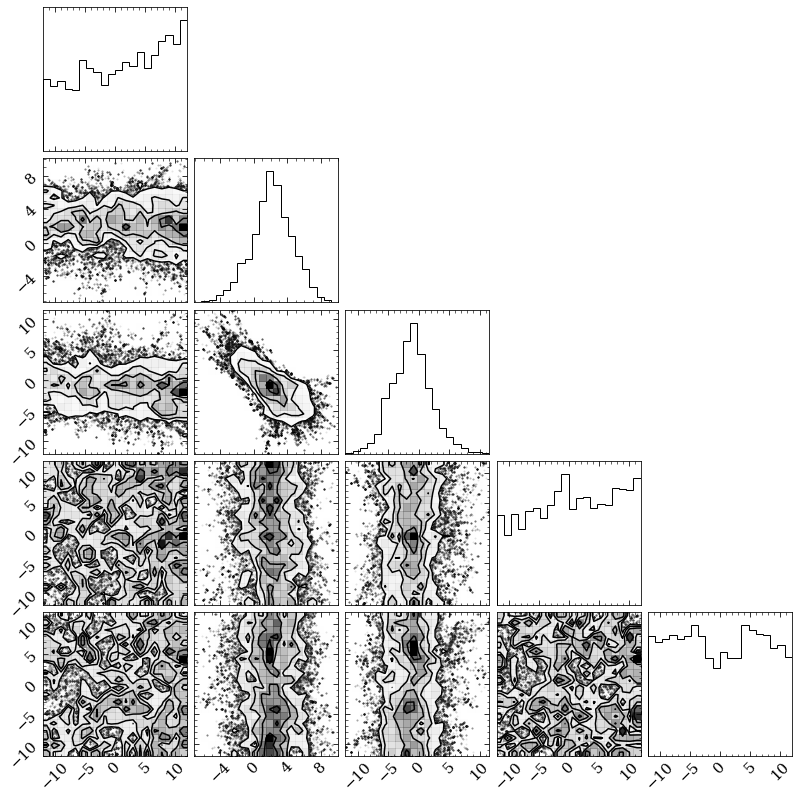

(100000, 5)


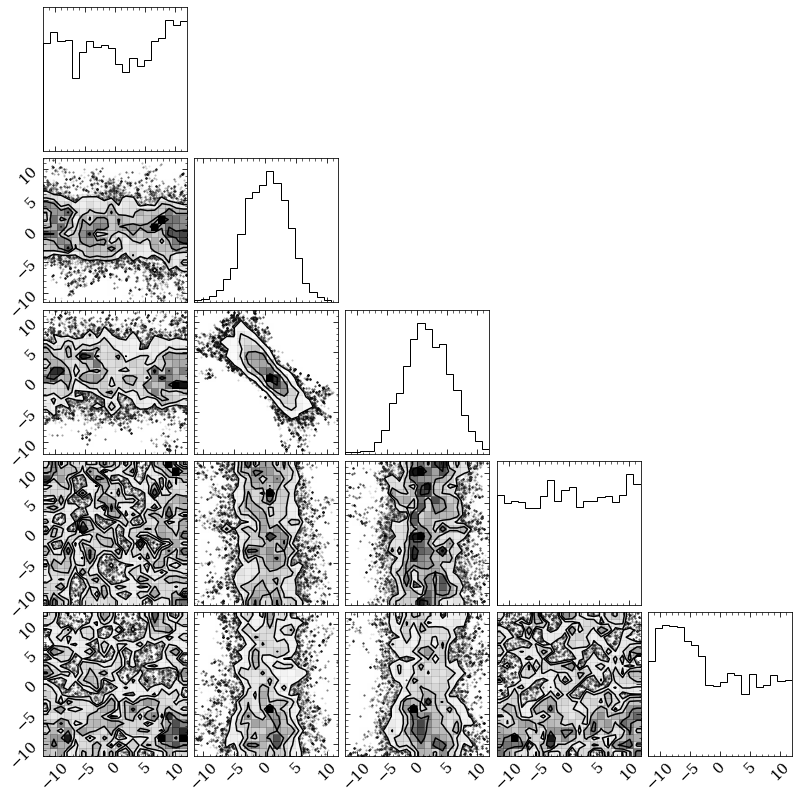

(100000, 5)


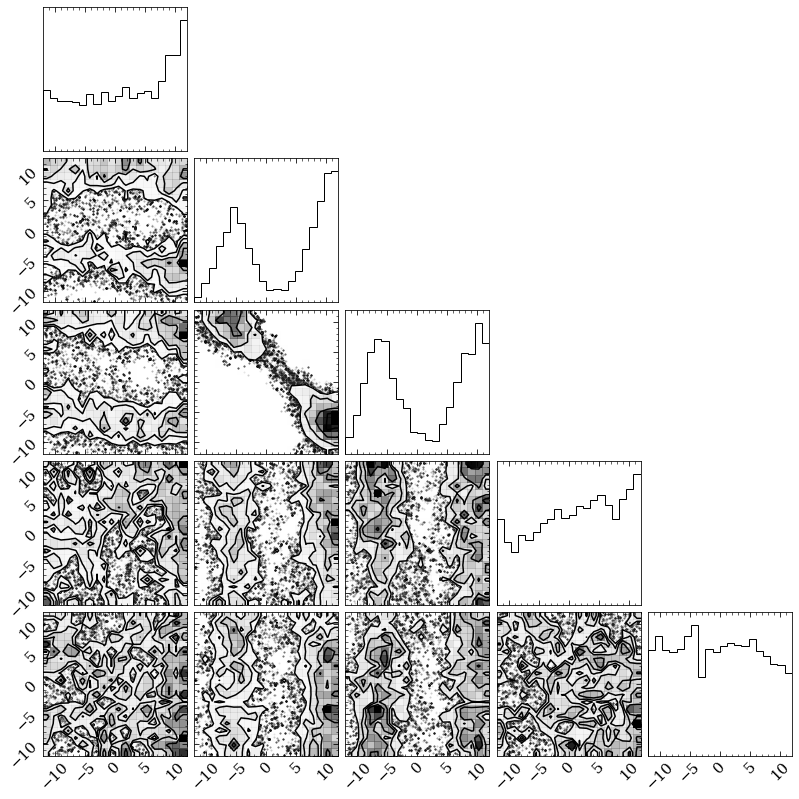

In [ ]:
def make_corner(sampler, labels, minval = 50):
    dim = sampler.chain.shape[-1]
    samples = sampler.chain[:, minval:, :].reshape((-1, dim))
    # print(samples)
    fig = corner.corner(samples, figsize = (20, 20), labels = labels)
    # for ax in fig.axes:
        # ax.set_xlim(-15, 15)
        # ax.set_ylim(-15, 15) 
    plt.show()

def make_corner_vonly(sampler, ndim, labels, minval = -100):
    samples = sampler.chain[:, minval:, :ndim].reshape((-1, ndim))
    print(samples.shape)
    # print(samples)
    fig = corner.corner(samples, figsize = (20, 20), labels = labels)
    # for ax in fig.axes:
        # ax.set_xlim(-15, 15)
        # ax.set_ylim(-15, 15) 
    plt.show()

if True:
    for i in range(0, len(sightlines), 4):
        sl_i = sightlines[i]
        ndim = len(sl_i.bins) - 1 
        make_corner_vonly(sl_i.sampler, ndim, labels = None, minval =-200)

N 0
(5, 95) (5, 5, 95) (5, 5)


/tmp/ipykernel_1941312/975238855.py:181: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc = 'lower left', fontsize = 20)


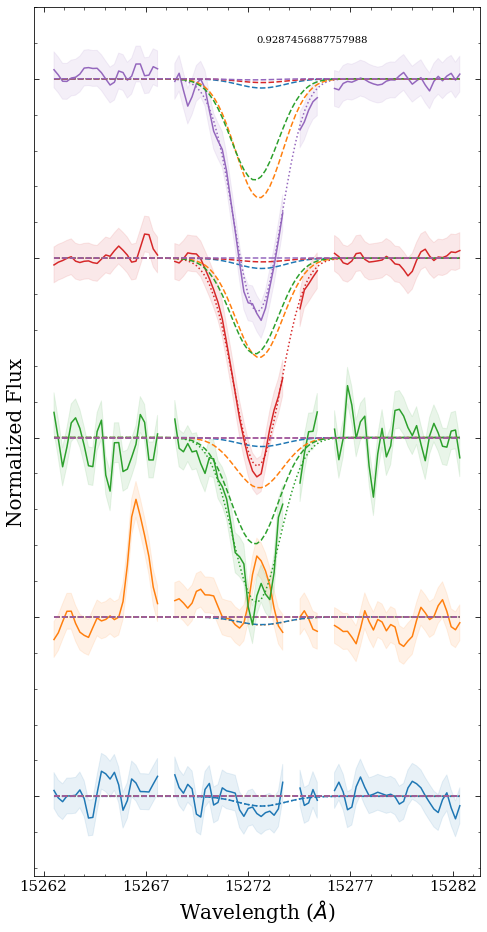

N 1
(5, 95) (5, 5, 95) (5, 5)


/tmp/ipykernel_1941312/975238855.py:181: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc = 'lower left', fontsize = 20)


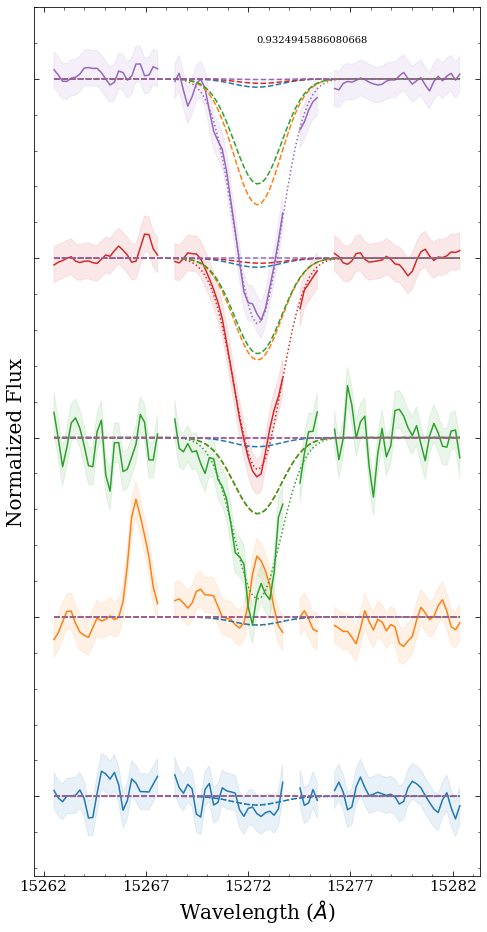

N 2
(5, 95) (5, 5, 95) (5, 5)


/tmp/ipykernel_1941312/975238855.py:181: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc = 'lower left', fontsize = 20)


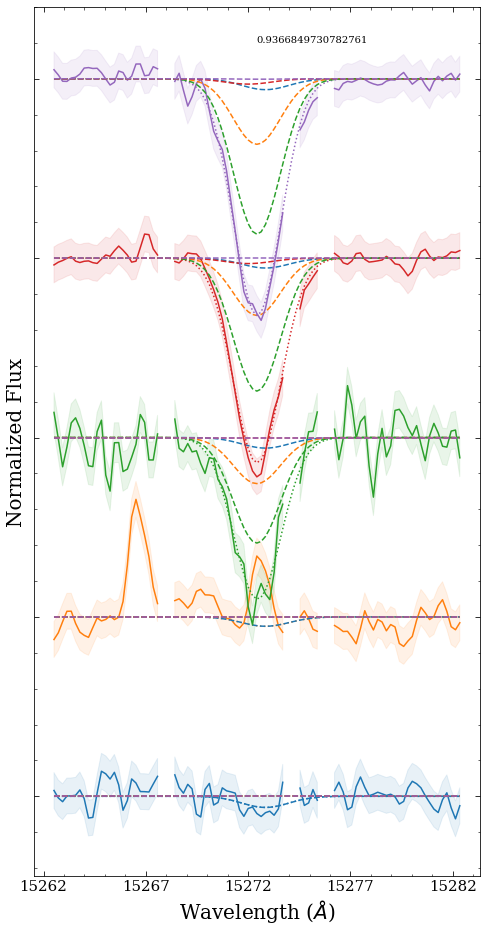

N 3
(5, 95) (5, 5, 95) (5, 5)


/tmp/ipykernel_1941312/975238855.py:181: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc = 'lower left', fontsize = 20)


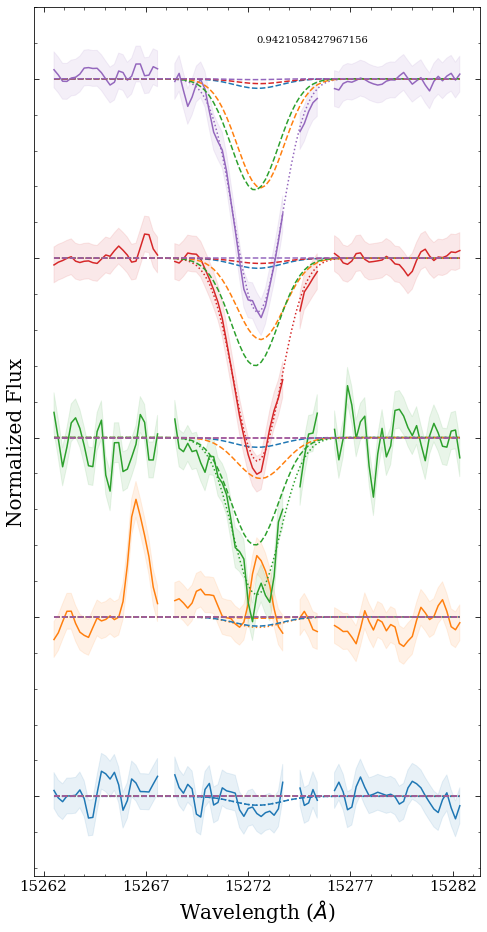

N 4
(5, 95) (5, 5, 95) (5, 5)


/tmp/ipykernel_1941312/975238855.py:181: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc = 'lower left', fontsize = 20)


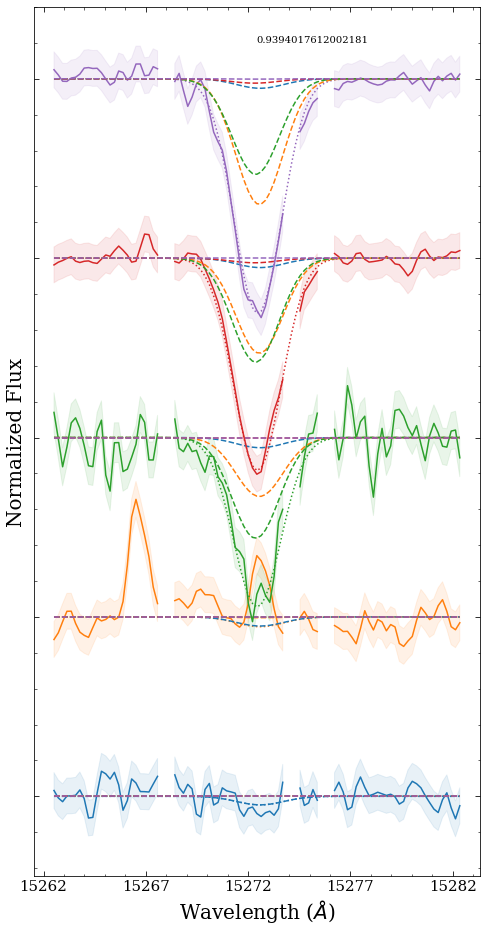

N 5
(5, 95) (5, 5, 95) (5, 5)


/tmp/ipykernel_1941312/975238855.py:181: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc = 'lower left', fontsize = 20)


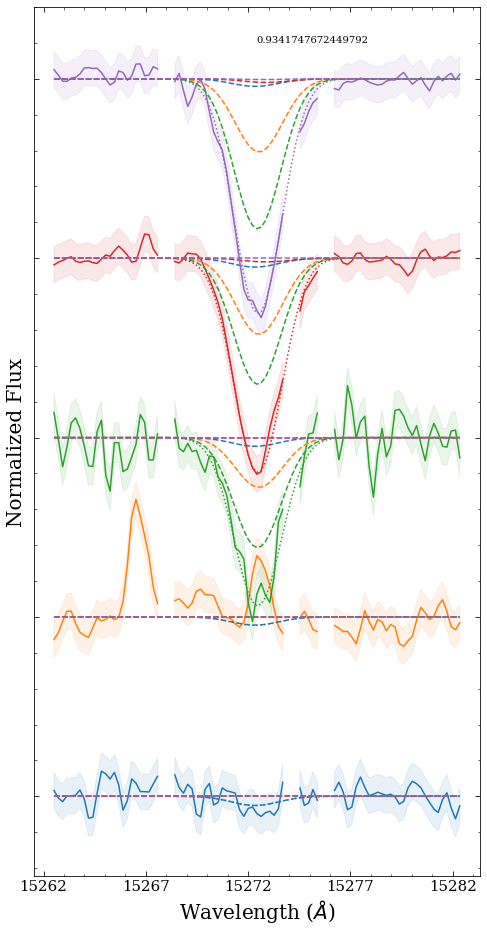

N 6
(5, 95) (5, 5, 95) (5, 5)


/tmp/ipykernel_1941312/975238855.py:181: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc = 'lower left', fontsize = 20)


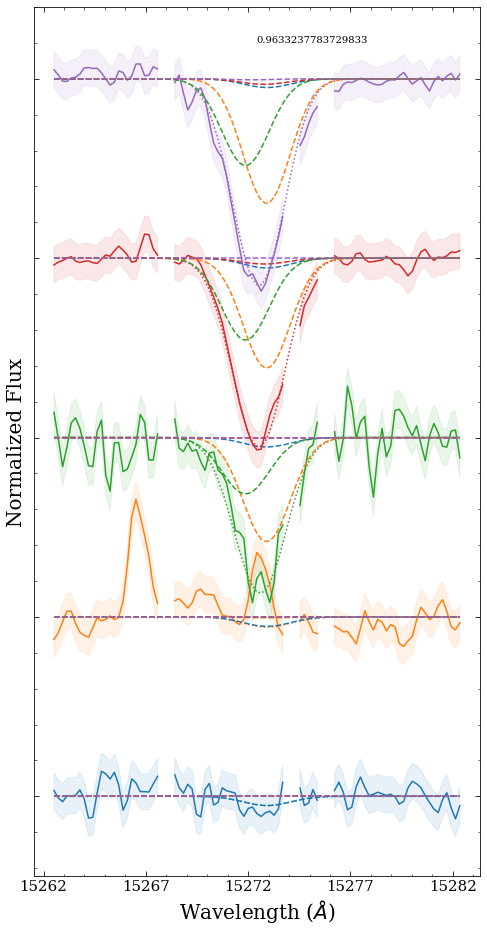

N 7
(5, 95) (5, 5, 95) (5, 5)


/tmp/ipykernel_1941312/975238855.py:181: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc = 'lower left', fontsize = 20)


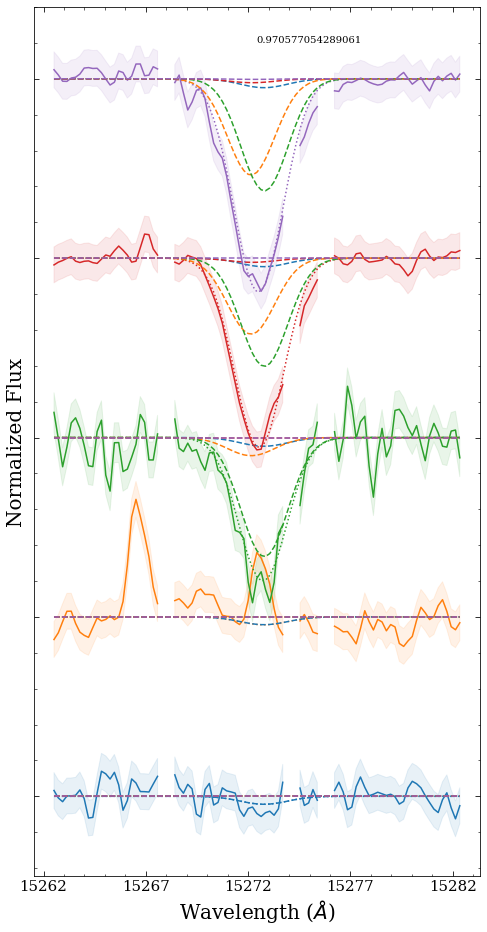

N 8
(5, 95) (5, 5, 95) (5, 5)


/tmp/ipykernel_1941312/975238855.py:181: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc = 'lower left', fontsize = 20)


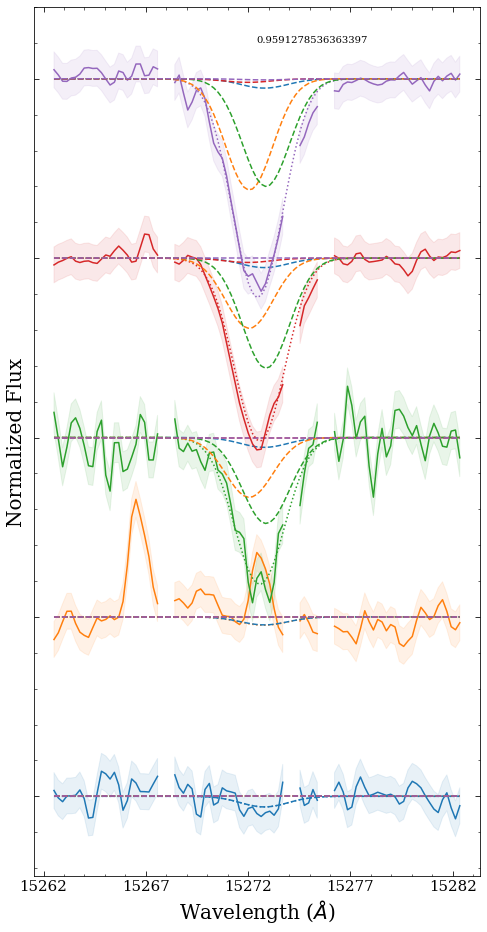

In [ ]:
def model_signals_thing(rvelo, sl, dAVdd):
    # dAVdd = sl.dAVdd
    signals = np.zeros((len(sl.stars), len(wavs_window)))
    unsummed_signals = np.zeros((len(sl.stars), len(sl.bins)-1,len(wavs_window)))
    print(signals.shape, unsummed_signals.shape, sl.dAVdd.shape)
    peak_wavelength = dopplershift(rvelo)
    wavs_grid = np.tile(wavs_window, (len(sl.bins) - 1, 1))
    voxel_DIB_unscaled = np.exp(-(wavs_grid - peak_wavelength[:, np.newaxis])**2 / (2 * sigma0**2))
    amp = differentialAmplitude(dAVdd, sl.bins[1:]-sl.bins[:-1])

    def single_signal(amp, bindex):
        amp[bindex:] = 0 # THIS MIGHT NEED TO BE -1
        # print(amp)

        voxel_DIB_scaled = -voxel_DIB_unscaled *  amp[:, np.newaxis] 
        summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
        # continuum = lambda x, m, b : m * (x - lambda0) + b
        # cont = continuum(wavs_window, 0, b)
        return summed_DIB  + 1, voxel_DIB_scaled 


    for i in range(len(sl.stars)):
        star = sl.stars[i]
        dAVdd_star = dAVdd[i, :]
        # amp = Differential_Amplitude(dAVdd_star, self.bins[1:]-self.bins[:-1])
        amp = differentialAmplitude(dAVdd_star, 1)

        bin_index = sl.bin_inds[i]
        # signals[i, :] = single_signal(bin_index)
        signals[i, :], unsummed_signals[i, :, :] = single_signal(amp, bin_index)

    return signals, unsummed_signals

def plot_DIBS_thing(sampler, sl, plot_objs = None):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8, 16))
    else:
        fig, ax = plot_objs
    # ax.plot(wavs_window, dstack1, label = '300-480 pc')
    # ax.plot(wavs_window, dstack2, label = '480-800 pc')
    ndim = len(sl.voxel_dAVdd)
    nstars = len(sl.stars)

    samples = sampler.chain[:, :, :].reshape((-1, sampler.chain.shape[-1]))

    medians = np.nanmedian(samples[-100:, :], axis = 0)

    # med_dAV_dd = np.nanmedian(samples[50:, :], axis = 0)

    # print(medians)
    med_velo = medians[:ndim]

    med_dAV_dd = medians[ndim:].reshape(-1, ndim)
    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)

    order_inds = np.array(np.argsort(sl.stars['DIST']))
    # print(order_inds)

    signal_recreated, signal_recreated_unsummed = model_signals_thing(med_velo, sl, med_dAV_dd) 
    # print('sru shape ', signal_recreated_unsummed.shape)
    # for i in range(len(sl.voxel_dAVdd)):
    for i in range(len(order_inds)):
        ii = order_inds[i]
        bindex = sl.bin_index[ii]
        # signal_recreated_here = sl.model_signals(med_velo[i], dAVdd = med_dAV_dd[i, :])
        ax.plot(wavs_window, sl.signals[ii, :] + 0.05 * i, color = 'C{}'.format(i))
        ax.fill_between(wavs_window, sl.signals[ii, :] + sl.signal_errs[ii, :] + 0.05 * i,
                         sl.signals[ii, :] - sl.signal_errs[ii, :] + 0.05 * i, color = 'C{}'.format(bindex), alpha = 0.1)

        ax.plot(wavs_window, signal_recreated[ii, :] + 0.05 * i , color = 'C{}'.format(i), linestyle = 'dotted',)# label = 'recreated signal')

        for j in range(len(sl.bins)-1):
            ax.plot(wavs_window, signal_recreated_unsummed[ii, j, : ] + 1 + 0.05 * i, color='C{}'.format(j), linestyle = 'dashed', alpha = 1)

    ax.legend(loc = 'lower left', fontsize = 20)

    ax.set_xlabel('Wavelength ($\AA$)', fontsize = 20)
    ax.set_ylabel('Normalized Flux', fontsize = 20)
    fig.set_facecolor('white')

    # ax.set_xticks(np.arange(lambda0-10, lambda0 + 12, 4))
    ax.set_xticks(np.linspace(lambda0-10, lambda0 + 10, 4))

    ax.set_yticklabels('')

def plot_DIBS_freeze(sampler, plot_objs = None):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8, 16))
    else:
        fig, ax = plot_objs
    # ax.plot(wavs_window, dstack1, label = '300-480 pc')
    # ax.plot(wavs_window, dstack2, label = '480-800 pc')
    ndim = len(sl.voxel_dAVdd)
    nstars = len(sl.stars)

    samples = sampler.chain[:, 50:, :].reshape((-1, sampler.chain.shape[-1]))

    medians = np.nanmedian(samples[50:, :], axis = 0)

    # med_dAV_dd = np.nanmedian(samples[50:, :], axis = 0)

    # print(medians)
    med_velo = medians[:ndim]

    med_dAV_dd = medians[ndim:].reshape(-1, ndim)
    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)

    order_inds = np.array(np.argsort(sl.stars['DIST']))
    # print(order_inds)

    signal_recreated, signal_recreated_unsummed = model_signals_thing(med_velo, sl, med_dAV_dd) 
    # print('sru shape ', signal_recreated_unsummed.shape)
    # for i in range(len(sl.voxel_dAVdd)):
    for i in range(len(order_inds)):
        ii = order_inds[i]
        # signal_recreated_here = sl.model_signals(med_velo[i], dAVdd = med_dAV_dd[i, :])
        ax.plot(wavs_window, sl.signals[ii, :] + 0.05 * i, color = 'C{}'.format(i))
        ax.plot(wavs_window, signal_recreated[ii, :] + 0.05 * i , color = 'C{}'.format(i), linestyle = 'dotted',)# label = 'recreated signal')

        for j in range(len(sl.bins)-1):
            ax.plot(wavs_window, signal_recreated_unsummed[ii, j, : ] + 1 + 0.05 * i, color='C{}'.format(j), linestyle = 'dashed', alpha = 1)

    ax.legend(loc = 'lower left', fontsize = 20)

    ax.set_xlabel('Wavelength ($\AA$)', fontsize = 20)
    ax.set_ylabel('Normalized Flux', fontsize = 20)
    fig.set_facecolor('white')

    ax.set_xticks(np.linspace(lambda0-10, lambda0 + 10, 8))
    ax.set_yticklabels('')

def plot_DIBS_logprob(sampler, sl, plot_objs = None, bestprob = True):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8, 16))
    else:
        fig, ax = plot_objs
    # ax.plot(wavs_window, dstack1, label = '300-480 pc')
    # ax.plot(wavs_window, dstack2, label = '480-800 pc')
    ndim = len(sl.voxel_dAVdd)
    nstars = len(sl.stars)

    samples = sampler.chain[:, :, :].reshape((-1, sampler.chain.shape[-1]))

    medians = np.nanmedian(samples[-100:, :], axis = 0)

    # med_dAV_dd = np.nanmedian(samples[50:, :], axis = 0)

    # print(medians)

    ## NEW THING
    if bestprob:
        lp = sl_i.sampler.lnprobability
        lp[:, :-100] = -np.infty
        w_ind, stp_ind = np.unravel_index(np.argmax(lp), lp.shape)

        medians = sl_i.sampler.chain[w_ind, stp_ind, :]

    med_velo = medians[:ndim]

    med_dAV_dd = medians[ndim:].reshape(-1, ndim)
    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)

    order_inds = np.array(np.argsort(sl.stars['DIST']))
    # print(order_inds)

    signal_recreated, signal_recreated_unsummed = model_signals_thing(med_velo, sl, med_dAV_dd) 
    # print('sru shape ', signal_recreated_unsummed.shape)
    # for i in range(len(sl.voxel_dAVdd)):
    for i in range(len(order_inds)):
        ii = order_inds[i]
        # signal_recreated_here = sl.model_signals(med_velo[i], dAVdd = med_dAV_dd[i, :])
        ax.plot(wavs_window, sl.signals[ii, :] + 0.05 * i, color = 'C{}'.format(i))
        ax.fill_between(wavs_window, sl.signals[ii, :] + sl.signal_errs[ii, :] + 0.05 * i,
                         sl.signals[ii, :] - sl.signal_errs[ii, :] + 0.05 * i, color = 'C{}'.format(i), alpha = 0.1)

        ax.plot(wavs_window, signal_recreated[ii, :] + 0.05 * i , color = 'C{}'.format(i), linestyle = 'dotted',)# label = 'recreated signal')

        for j in range(len(sl.bins)-1):
            ax.plot(wavs_window, signal_recreated_unsummed[ii, j, : ] + 1 + 0.05 * i, color='C{}'.format(j), linestyle = 'dashed', alpha = 1)

    ax.legend(loc = 'lower left', fontsize = 20)

    ax.set_xlabel('Wavelength ($\AA$)', fontsize = 20)
    ax.set_ylabel('Normalized Flux', fontsize = 20)
    fig.set_facecolor('white')

    # ax.set_xticks(np.arange(lambda0-10, lambda0 + 12, 4))
    ax.set_xticks(np.linspace(15272-10, 15272 + 10, 5))

    ax.set_yticklabels('')

    return signal_recreated, sl.signals, sl.signal_errs

chi2s = np.zeros(len(sightlines))
sl_lensignals = np.zeros(len(sightlines))
for i in range(len(sightlines)):
    print('N', i)
    fig, ax = plt.subplots(figsize = (8, 16))

    sl_i = sightlines[i]
    sl_lensignals[i] = sl_i.nsig
    sampler_i = sl_i.sampler
    reproducedDIBs, realDIBs, realDIBerrs = plot_DIBS_logprob(sampler_i, sl_i, plot_objs = (fig, ax))

    chi2 = np.nansum((realDIBs-reproducedDIBs)**2 / realDIBerrs**2) / np.sum(np.isnan(realDIBs)==False)
    chi2s[i] = chi2

    ymin, ymax = ax.get_ylim()
    ax.text(lambda0, ymax - .01, str(chi2))

    lp_i = sampler_i.lnprobability
    lp_med_i = np.nanmedian(lp_i[:, -100:])
    # ax.text(lambda0, ymax - .01, 'sl index {}'.format(i) )
    # ax.text(lambda0, ymax - .015, 'lnprob {}'.format(lp_med_i) )

    name_i = 'dibs_' + str(i)
    # fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/231015_DIBmodels/{}.png'.format(name_i), overwrite = True)

    plt.show()




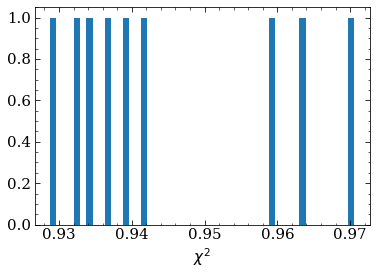

In [ ]:
fig, ax = plt.subplots()
ax.hist(chi2s, bins = 50)
ax.set_xlabel('$\chi^2$')
plt.show()

In [ ]:
sl_davdd = np.zeros((len(l_sample.flatten()), dust_data.dustmap.shape[-1]))
for i in range(len(l_sample.flatten())): 
    l_i, b_i = l_sample.flatten()[i], b_sample.flatten()[i]
    l_ind, b_ind = find_nearest(l_i, b_i)
    sl_davdd[i, :] = np.copy(dust_data.dustmap[b_ind, l_ind, :])
    sl_davdd[i, :] = diff_AV

In [ ]:
def plot_velo(sampler, sl , min_walker = None, plot_objs = None, color = None, plot_lines = False, plot_box = False, plot_violin = False, bestprob = False,):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8,6))
    else:
        fig, ax = plot_objs
    # ax.plot(wavs_window, dstack1, label = '300-480 pc')
    # ax.plot(wavs_window, dstack2, label = '480-800 pc')
    ndim = len(sl.voxel_dAVdd)

    walker_max = sampler.chain.shape[1]

    if min_walker is None:
        min_walker_val = -100
    # else:
    min_walker_val = walker_max - min_walker

    samples = sampler.chain[:, min_walker_val:, :].reshape((-1, sampler.chain.shape[-1]))

    # vel_samples = sampler.chain[:, min_walker_val, :].reshape((-1, sl.ndim))
    vel_samples = samples[:, :sl.ndim]
    avg_av = np.nansum(np.median(sl.dAVdd, axis = 0))

    


    medians = np.nanmedian(samples[min_walker_val:, :], axis = 0)
    if bestprob:
        lp = sl_i.sampler.lnprobability
        lp[:, :-100] = -np.infty
        w_ind, stp_ind = np.unravel_index(np.argmax(lp), lp.shape)

        medians = sl_i.sampler.chain[w_ind, stp_ind, :]

    stdevs = np.nanstd(samples[min_walker_val:, :], ddof = 1, axis = 0)

    med_velo = medians[:ndim]
    std_velo = stdevs[:ndim]


    med_dAV_dd = medians[ndim:]
    med_dAV_dd = stdevs[ndim:]

    perc16, perc50,  perc84 = (np.percentile(samples[min_walker_val:, :], 16, axis = 0), 
                               np.percentile(samples[min_walker_val:, :], 50, axis = 0),
                               np.percentile(samples[min_walker_val:, :], 84, axis = 0) )
    velo16, velo50, velo84 = (perc16[:ndim], perc50[:ndim], perc84[:ndim])

    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)


    # ax.scatter((a.bins[1:] + a.bins[:-1] ) /2 , med_velo)
    # if
    # for i in range(len(sl.bins)-1): 
    #     ax.hlines(med_velo[i], sl.bins[i], sl.bins[i+1], linestyle = 'dashed')
    #     if i < len(sl.bins) -2:
    #         ax.vlines(sl.bins[i+1], med_velo[i], med_velo[i+1], linestyle = 'dashed')

    if color == None:
        color_choice = 'k'
    else:
        color_choice = color
    

    if plot_box:
        # ax.hlines(med_velo, sl.bins[:-1], sl.bins[1:], color = color_choice, linestyle = 'dashed', linewidth = 0.5)
        # ax.hlines(velo50, sl.bins[:-1], sl.bins[1:], color = color_choice)
        ax.hlines(velo50, sl.bins[:-1], sl.bins[1:], color = 'k')


        for j in range(len(sl.bins)-1):
            # ax.fill_between([sl.bins[i], sl.bins[i +1]], med_velo[i]+std_velo[i], med_velo[i]-std_velo[i], 
            #                 alpha = 0.3, color = color_choice, hatch = '/')
            ax.fill_between([sl.bins[j], sl.bins[j +1]], velo84[j], velo16[j], 
                    alpha = 0.3, color = 'C{}'.format(j))

        if plot_violin:
            
            pos = (sl.bins[1:] + sl.bins[:-1])/2
            w = (sl.bins[1:] - sl.bins[:-1])
            ax.violinplot(vel_samples, pos, widths = w, showmeans=True, showextrema=False, showmedians=True)



    else:  
        # ax.errorbar((sl.bins[1:] + sl.bins[:-1] ) /2 , med_velo, yerr = std_velo, fmt = '.', color = color_choice, capsize = 5)
        # ax.scatter((sl.bins[1:] + sl.bins[:-1] ) /2 , med_velo, c = color_choice)
        ax.errorbar((sl.bins[1:] ) , med_velo, yerr = std_velo, fmt = '.', color = color_choice, capsize = 5)
        ax.scatter((sl.bins[1:] ) , med_velo, c = color_choice)
        if plot_lines:
            ax.hlines(med_velo, sl.bins[:-1], sl.bins[1:], color = color_choice, linestyle = 'solid', linewidth = .5)



    # ax.errorbar((sl.bins[1:]),med_velo, xerr = (sl.bins[1:] - sl.bins[:-1], np.zeros(med_velo.shape)), yerr = std_velo, fmt = '.' )
    ax.set_xlim(350, 600)
    ax.set_xlabel('Distance (pc)')
    ax.set_ylabel('Radial Velocity (km/s)')

    dist_xx = (sl.bins[1:] + sl.bins[:-1] ) /2
    # med_velo

    return fig, ax, dist_xx, med_velo, std_velo


In [ ]:
for i in range(len(sightlines)):
    print(i, i//3, i%3)

0 0 0
1 0 1
2 0 2
3 1 0
4 1 1
5 1 2
6 2 0
7 2 1
8 2 2


N  0
[ 78.93037415 288.17993164 472.06390381 547.76434326 577.60766602]
[ 4.82332179  2.36848996 -1.77596967  5.26930044 -4.01774414]
[472.06390381 547.76434326 577.60766602]
(array([ 0.01599345, -8.96987653]), array([[ 4.23343421e-03, -2.11493831e+00],
       [-2.11493831e+00,  1.06414386e+03]]))


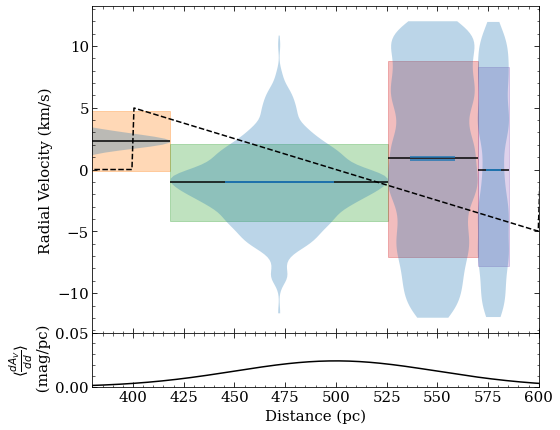

N  1
[ 78.93037415 288.17993164 472.06390381 547.76434326 577.60766602]
[0.18000814 0.7413694  1.17090908 3.56367552 6.21677872]
[472.06390381 547.76434326 577.60766602]
(array([  0.04283546, -19.10001743]), array([[ 8.28910740e-05, -4.14262594e-02],
       [-4.14262594e-02,  2.08535967e+01]]))


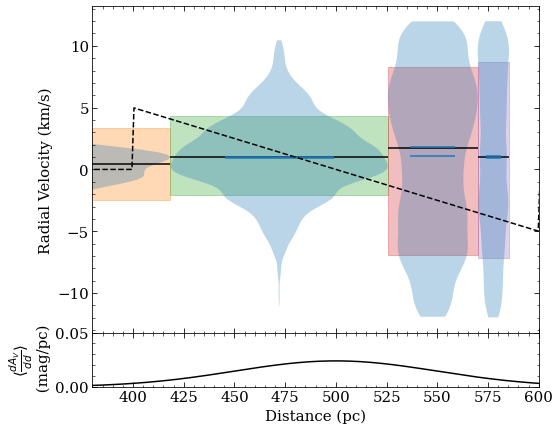

N  2
[ 78.93037415 288.17993164 472.06390381 547.76434326 577.60766602]
[ 8.39084852  0.13620696  0.26799385 -7.9621439   3.28056254]
[472.06390381 547.76434326 577.60766602]
(array([-0.014239  ,  6.70440668]), array([[ 5.35435267e-03, -2.63914012e+00],
       [-2.63914012e+00,  1.30890150e+03]]))


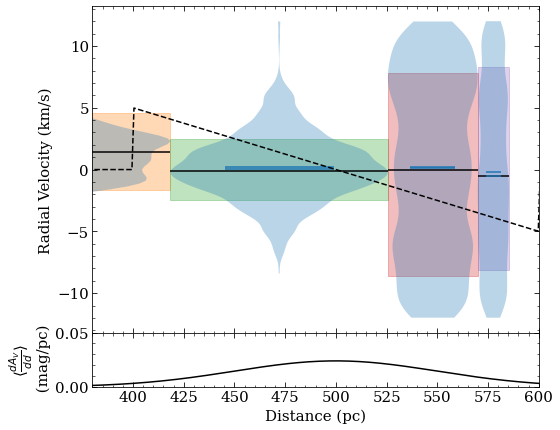

N  3
[ 78.93037415 288.17993164 472.06390381 547.76434326 577.60766602]
[ 0.98907092  3.7606308  -1.71760391  3.11087908 -2.45200871]
[472.06390381 547.76434326 577.60766602]
(array([ 0.01294524, -7.58984562]), array([[ 1.57779436e-03, -7.92412034e-01],
       [-7.92412034e-01,  4.01000263e+02]]))


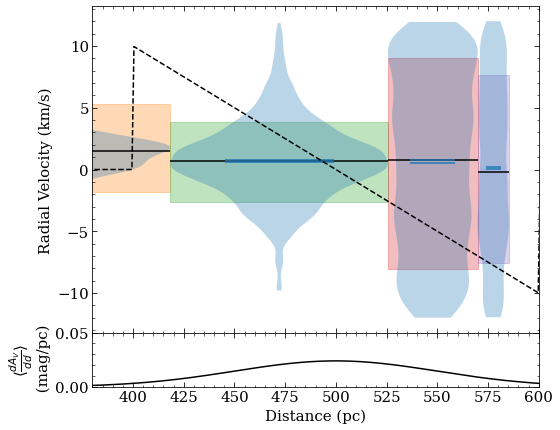

N  4
[ 78.93037415 288.17993164 472.06390381 547.76434326 577.60766602]
[ 3.29320809  2.56017387 -0.99787667 -2.15449467 -0.23613949]
[472.06390381 547.76434326 577.60766602]
(array([ 9.78030571e-04, -1.55343149e+00]), array([[ 1.72184564e-04, -8.72238436e-02],
       [-8.72238436e-02,  4.45365955e+01]]))


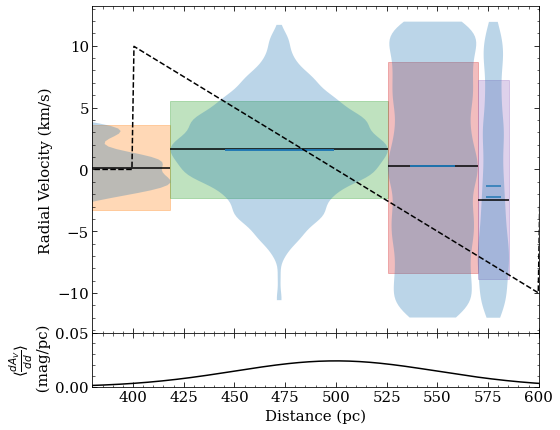

N  5
[ 78.93037415 288.17993164 472.06390381 547.76434326 577.60766602]
[-1.53899538  2.11344928  0.75640752  8.96319054  5.15821555]
[472.06390381 547.76434326 577.60766602]
(array([  0.06404136, -29.30804487]), array([[ 1.36466061e-03, -6.76225537e-01],
       [-6.76225537e-01,  3.37293801e+02]]))


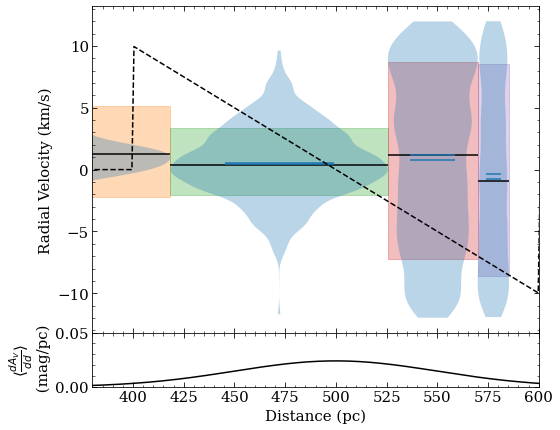

N  6
[ 78.93037415 288.17993164 472.06390381 547.76434326 577.60766602]
[  9.90603008   9.48008048 -10.74364341   7.12428286  -4.51785441]
[472.06390381 547.76434326 577.60766602]
(array([  0.09221414, -51.92577317]), array([[ 1.87132116e-02, -9.96672850e+00],
       [-9.96672850e+00,  5.34554863e+03]]))


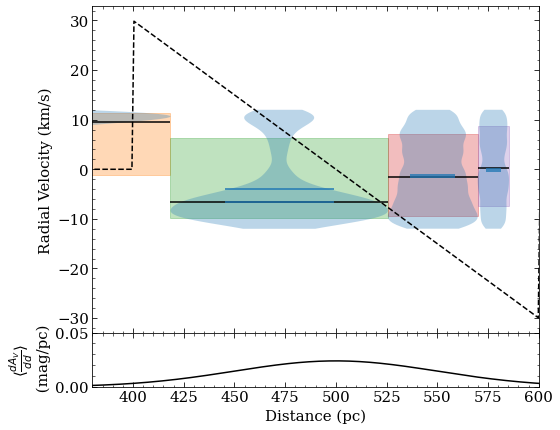

N  7
[ 78.93037415 288.17993164 472.06390381 547.76434326 577.60766602]
[ 7.00803862 -5.36311488  7.37007985 -4.15492314 -2.08269133]
[472.06390381 547.76434326 577.60766602]
(array([-0.10043717, 53.88294825]), array([[ 2.45350323e-03, -1.31107887e+00],
       [-1.31107887e+00,  7.05368409e+02]]))


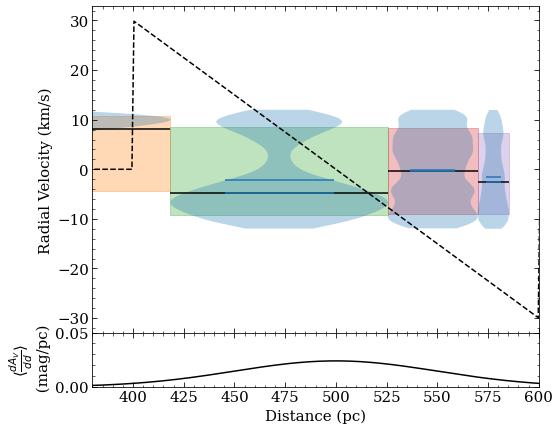

N  8
[ 78.93037415 288.17993164 472.06390381 547.76434326 577.60766602]
[ 7.31716921 -7.13338787  8.91000097 -8.37471273  7.56758497]
[472.06390381 547.76434326 577.60766602]
(array([-0.05000995, 29.01637189]), array([[ 3.19474501e-02, -1.71268612e+01],
       [-1.71268612e+01,  9.24049860e+03]]))


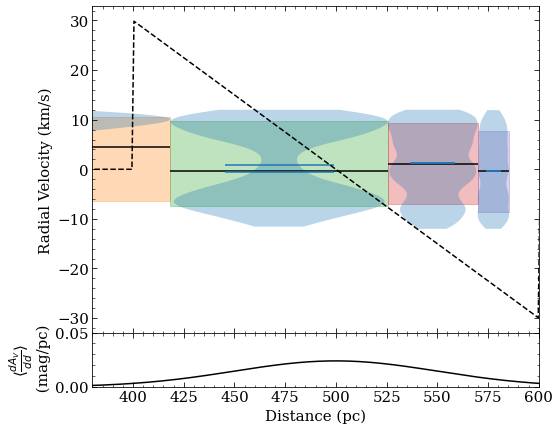

In [ ]:
avs = np.zeros(len(sightlines))
for i in range(len(sightlines)):
    sl_i = sightlines[i]
    avs[i] = np.sum(sl_i.voxel_dAVdd)

line = lambda x, m, b : m * x + b

cnorm = matplotlib.colors.Normalize(np.min(avs), np.max(avs))
cmap = plt.get_cmap('viridis')
mappable = matplotlib.cm.ScalarMappable(norm = cnorm,  cmap = cmap)


sightlines_slopes = np.zeros(len(sightlines))
sightlines_slopes_err = np.zeros(len(sightlines))


dist_xx_sl = np.array([])
velo_yy_sl = np.array([])
std_velo_sl = np.array([])


for i in range(len(sightlines)): 
    print('N ', i)
    fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (8,7), sharex = True, gridspec_kw={'height_ratios': [6,1], 'hspace': 0})


    dist_xx = np.array([])
    velo_yy = np.array([])
    std_velo = np.array([])
    sl_i = sightlines[i]
    sampler_i = sl_i.sampler
    color = cmap(cnorm(avs[i]))
    color = 'C'+str(i)
    _, __, dist_xx_i, velo_yy_i, std_velo_i = plot_velo(sampler_i, sl = sl_i, min_walker = 10, plot_objs = (fig, axs[0]), color = color, plot_box = True, plot_violin=True, bestprob = True)
    dist_xx = np.concatenate([dist_xx, dist_xx_i])
    velo_yy = np.concatenate([velo_yy, velo_yy_i])
    std_velo = np.concatenate([std_velo, std_velo_i])

    print(dist_xx)
    print(velo_yy)

    dist_sort = np.argsort(dist_xx)
    # print(dist_sort)

    try:
        filt = (dist_xx[dist_sort] >= 380) & (dist_xx[dist_sort] <= 600)
        print(dist_xx[dist_sort][filt])
        fit_result = curve_fit(line, dist_xx[dist_sort][filt], velo_yy[dist_sort][filt], sigma = std_velo[dist_sort][filt])
        print(fit_result)
        fit_params = fit_result[0]
        fit_result_err = np.sqrt(np.diag(fit_result[1]))
        xx_plot = np.linspace(380, 600)

        # axs[0].plot(xx_plot, line(xx_plot, fit_params[0], fit_params[1]), label = 'SL ' + str(i))
        sightlines_slopes[i] = fit_params[0] 
        sightlines_slopes_err[i] = fit_result_err[0]
    except Exception as e:
        print('didn\'t fit properly')
        print(e)
        sightlines_slopes[i] = np.nan

    # ax.plot(sl.stars['DIST'], )
    # axs[0].fill_between(xx_plot, line(xx_plot, fit_params[0] + fit_result_err[0], fit_params[1] + fit_result_err[1]),
    #                     line(xx_plot, fit_params[0] - fit_result_err[0], fit_params[1] - fit_result_err[1]), alpha = 0.1, color = 'C0')

    # ymin, ymax = ax.get_ylim()
    axs[1].plot(dust_data.distance, sl_davdd[i, :], color = 'k')
    # ax.set_ylim(ymin, ymax)
    axs[1].set_xlim(380, 600)
    axs[1].set_xlabel('Distance (pc)')
    axs[1].set_ylabel(r'$ \langle \frac{dA_V}{dd} \rangle $' + '\n (mag/pc)')
    axs[1].set_ylim(0, 0.05)
    fig.set_facecolor('white')

    rvelo, star_loc_rvelo_scattered, star_locs = velo_profile(velocity_range[i//len(velocity_range)], scale_range[i%len(velocity_range)])
    axs[0].plot(dust_data.distance, rvelo, color = 'k', linestyle = 'dashed')
    # for j in range(len(sl_i.stars)):
    #     axs[1].scatter(sl_i.stars['DIST'][j], sl_davdd[i, find_nearest_dist(sl_i.stars['DIST'][j])])

    # axs[0].legend()
    name_i = 'veldist_' + str(i)
    # fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/2301015_veldist/{}.png'.format(name_i), overwrite = True )

    plt.show()

    dist_xx_sl = np.concatenate([dist_xx_sl, dist_xx])
    velo_yy_sl = np.concatenate([velo_yy_sl, velo_yy])
    std_velo_sl = np.concatenate([std_velo_sl, std_velo])

In [ ]:
from scipy.stats import spearmanr 

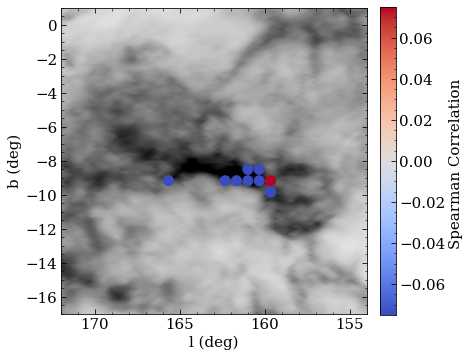

In [ ]:
from scipy.stats import spearmanr
start = 0
stop = None
def gradientmetric_deriv(array, dist):    
    a, b = np.meshgrid(array, array)
    c, d = np.meshgrid(dist, dist)
    grad_matrix = np.triu(b - a)
    deltadist = np.triu(d - c)
    nz = grad_matrix != 0
    grad_matrix[nz] = grad_matrix[nz] / deltadist[nz]
    shape = grad_matrix.shape[0]
    return np.sum(grad_matrix) / (0.5 * shape * (shape - 1))

sl_metrics = np.zeros(len(sightlines))
sl_spearman = np.zeros((len(sightlines), 2))

# sl_spearman_samples = np.zeros((len(sightlines), 2))


v_all = np.array([], dtype = float)
verr_all = np.array([], dtype = float)
d_all = np.array([], dtype = float)
l_sightline = np.array([], dtype = float)
sl_counts = np.zeros(len(sightlines))
median_velo_sightline = np.zeros(len(sightlines))

v_samp = []

velocity_samples_all = np.array([])
distance_samples_all = np.array([])

vperc16_all = np.array([], dtype = float)
vperc84_all = np.array([], dtype = float)

spearman_stats_sampledraw = np.zeros((20 * len(sightlines), 2))


for i in range(len(sightlines)):
    sl_i = sightlines[i]
    ndim = len(sl_i.voxel_dAVdd)
    walker_max = sl_i.sampler.chain.shape[1]
    min_walker_val = walker_max - 100
    sampler = sl_i.sampler
    samples = sampler.chain[:, min_walker_val:, :].reshape((-1, sampler.chain.shape[-1]))
    medians = np.nanmedian(samples[min_walker_val:, :], axis = 0)
    stdevs = np.nanstd(samples[min_walker_val:, :], ddof = 1, axis = 0)
    perc16= np.percentile(samples[min_walker_val:, :], 16, axis = 0)
    perc84 = np.percentile(samples[min_walker_val:, :], 16, axis = 0)

    med_velo = medians[:ndim]
    std_velo = stdevs[:ndim]
    perc16_velo = perc16[:ndim]
    perc84_velo = perc84[:ndim]
    bin_dist = sl_i.bins[1:]
    vperc16_all = np.concatenate([vperc16_all, perc16_velo])
    vperc84_all = np.concatenate([vperc84_all, perc84_velo])

    select_cloud = bin_dist > 401

    median_velo_sightline[i] = np.nanmedian(samples[:, :ndim])

    metric = np.sum(gradientmetric_deriv(med_velo[select_cloud], bin_dist[select_cloud]))
    sl_metrics[i] = metric

    spearman_correlation = spearmanr(bin_dist[select_cloud], med_velo[select_cloud])
    sl_spearman[i, 0] = spearman_correlation.correlation
    sl_spearman[i, 1] = spearman_correlation.pvalue

    v_all = np.concatenate([v_all,med_velo])
    verr_all = np.concatenate([verr_all, std_velo]) 
    d_all = np.concatenate([d_all, bin_dist])

    l_sightline = np.concatenate([l_sightline, l_sample[i] * np.ones(len(med_velo))])
    sl_counts[i] = len(med_velo)
    
    velocity_samples = (samples[:, :ndim])
    distance_samples = (np.ones(velocity_samples.shape) * bin_dist)
    # select_cloud_samples = distance_samples > 401
    # spearman_samples = spearmanr(distance_samples[select_cloud_samples].flatten(), velocity_samples[select_cloud_samples].flatten(),)
    # sl_spearman_samples[i, 0] = spearman_samples.correlation
    # sl_spearman_samples[i, 1] = spearman_samples.pvalue
    
    # distance_samples_all = np.concatenate([distance_samples_all, distance_samples.flatten()])
    # velocity_samples_all = np.concatenate([velocity_samples_all, velocity_samples.flatten()])
    
    
    v_samp.append(velocity_samples)

    for j in range(20):
        idx = np.random.choice(samples.shape[0], size = 100)
        select_cloud_walkers = bin_dist > 401
        draws= np.array([np.random.choice(velocity_samples[:, k]) for k in range(velocity_samples.shape[1])])
        spearman_samples = spearmanr(bin_dist[select_cloud_walkers], draws[select_cloud_walkers],)
        spearman_stats_sampledraw[i*20 + j, 0] = spearman_samples.correlation
        spearman_stats_sampledraw[i*20 + j, 1] = spearman_samples.pvalue


fig, ax = plt.subplots(figsize = (6,6))
im = ax.imshow(np.nansum(dust_data.dustmap, axis = 2), origin = 'lower', cmap = 'binary', vmin = 0, vmax = 3, extent = (dust_data.l0-9, dust_data.l0+9, dust_data.b0-9, dust_data.b0+9))
points = ax.scatter(l_sample[:len(sightlines)], b_sample[:len(sightlines)], c = sl_spearman[:, 0], s= 100, vmin = -0.075, vmax = 0.075, cmap = 'coolwarm')
ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmax, xmin)
# fig.colorbar(im, label = "A(V)")
fig.colorbar(points, label = 'Spearman Correlation ',fraction=0.046, pad=0.04)
plt.show()

# fig, ax = plt.subplots(figsize = (6,6))
# im = ax.imshow(np.nansum(dust_data.dustmap, axis = 2), origin = 'lower', cmap = 'binary', vmin = 0, vmax = 3, extent = (dust_data.l0-9, dust_data.l0+9, dust_data.b0-9, dust_data.b0+9))
# points = ax.scatter(l_sample[:len(sightlines)], b_sample[:len(sightlines)], c = sl_spearman_samples[:, 0], s= 100 * (1-sl_spearman_samples[:, 1]), vmin = -0.075, vmax = 0.075, cmap = 'coolwarm')
# ax.set_xlabel('l (deg)')
# ax.set_ylabel('b (deg)')
# xmin, xmax = ax.get_xlim()
# ax.set_xlim(xmax, xmin)
# # fig.colorbar(im, label = "A(V)")
# fig.colorbar(points, label = 'Spearman Correlation ')
# plt.show()

# sl_spearman.astype(np.float16)
# fig, ax = plt.subplots()
# fil = np.nansum(crit_filament)
# fil_idx = np.sum(sl_counts[:fil]).astype(int)

# ax.errorbar(d_all[:], v_all[:], yerr = verr_all[:], fmt = '.', capsize = 4, color = 'grey')

# points = ax.scatter(d_all[:], v_all[:], c = l_sightline[:], zorder = 5, )

# ax.set_xlim(380, 600)
# ax.set_xlabel('Distance (pc)')
# ax.set_ylabel('Velocity (km/s)')
# fig.colorbar(points, label = 'l (deg)')
# plt.show()

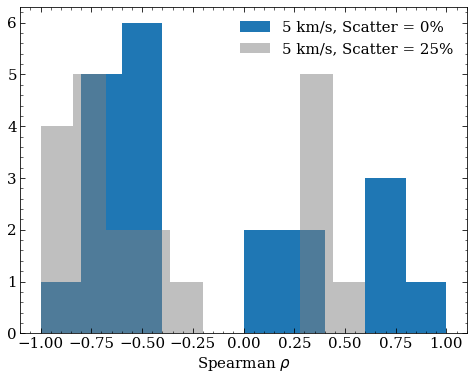

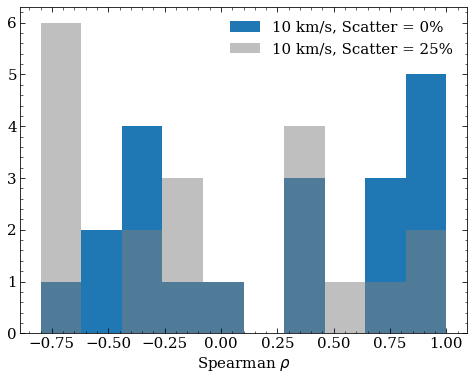

In [ ]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.hist(spearman_stats_sampledraw[0*20:0*20+20, 0], label = r'5 km/s, Scatter = 0%')
ax.hist(spearman_stats_sampledraw[2*20:2*20+20, 0], histtype = 'bar', label = r'5 km/s, Scatter = 25%', alpha = 0.5, color = 'grey')

ax.legend()
ax.set_xlabel(r'Spearman $\rho$')

plt.show()

fig, ax = plt.subplots(figsize = (8, 6))
ax.hist(spearman_stats_sampledraw[3*20:3*20+20, 0], label = r'10 km/s, Scatter = 0%')
ax.hist(spearman_stats_sampledraw[5*20:5*20+20, 0], histtype = 'bar', label = r'10 km/s, Scatter = 25%', alpha = 0.5, color = 'grey')

ax.set_xlabel(r'Spearman $\rho$')
ax.legend()
plt.show()


# plt.hist2d(spearman_stats_sampledraw[:20, 0], spearman_stats_sampledraw[:20,1])

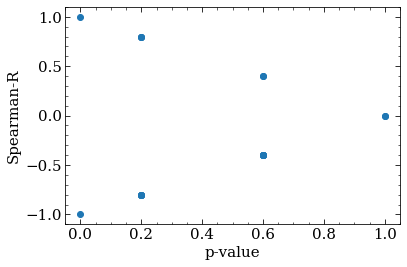

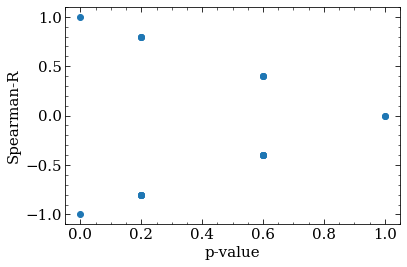

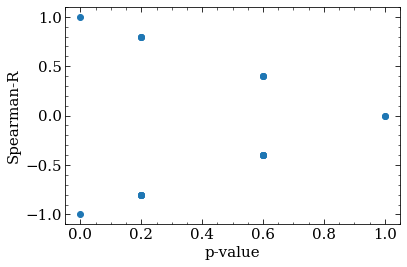

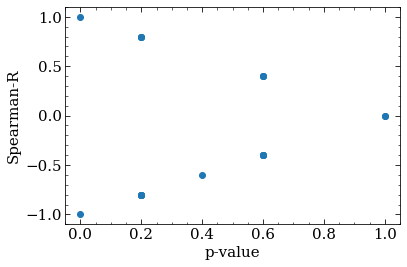

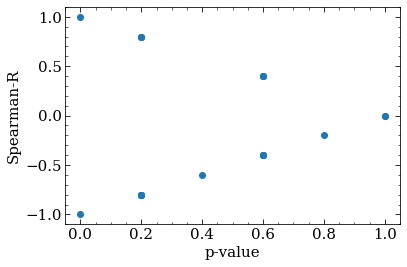

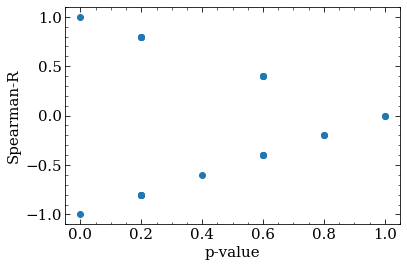

In [ ]:
for i in range(len(sightlines)-3):
    fig, ax = plt.subplots()
    ax.scatter(spearman_stats_sampledraw[i:i+20, 1], spearman_stats_sampledraw[i:i+20, 0])
    ax.set_xlabel('p-value')
    ax.set_ylabel('Spearman-R')
    plt.show()


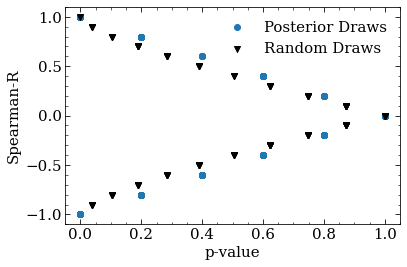

In [ ]:

spearman_random_draw = np.zeros((20 * len(sightlines), 2))
for i in range(20 * len(sightlines)):
    random_y = 20 * (np.random.random(5) - 10)
    random_x = np.linspace(400, 60, 5) + 10 * (np.random.random(5) - 5)
    spearman_random = spearmanr(random_x, random_y)
    spearman_random_draw[i, 0] = spearman_random.correlation
    spearman_random_draw[i, 1] = spearman_random.pvalue

fig, ax = plt.subplots()
ax.scatter(spearman_stats_sampledraw[:, 1], spearman_stats_sampledraw[:, 0], marker = 'o', color = 'C0', label = 'Posterior Draws')
ax.scatter(spearman_random_draw[:, 1], spearman_random_draw[:, 0], marker = 'v', label = 'Random Draws', color = 'k')
ax.set_xlabel('p-value')
ax.set_ylabel('Spearman-R')
ax.legend()
plt.show()


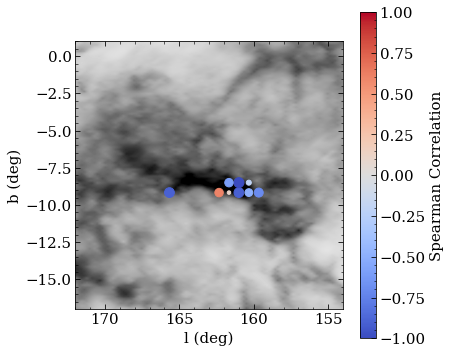

In [ ]:
fig, ax = plt.subplots(figsize = (6,6))
im = ax.imshow(np.nansum(dust_data.dustmap, axis = 2), origin = 'lower', cmap = 'binary', vmin = 0, vmax = 3, extent = (dust_data.l0-9, dust_data.l0+9, dust_data.b0-9, dust_data.b0+9))
# masks = (np.nansum(edenhofer, axis = 2) >= 2.2).astype(float)
# masks_3 = (np.nansum(edenhofer, axis = 2) < 1.5).astype(float)
# im_mask = ax.imshow(np.nansum(edenhofer, axis = 2), origin = 'lower', cmap = 'Reds', alpha = masks, extent = (l0-9, l0+9, b0-9, b0+9))
# im_mask_3 = ax.imshow(np.nansum(edenhofer, axis = 2), origin = 'lower', cmap = 'Purples', alpha = masks_3, extent = (l0-9, l0+9, b0-9, b0+9))
points = ax.scatter(l_sample[:len(sightlines)], b_sample[:len(sightlines)], c = sl_spearman[:len(sightlines), 0], s= 100 * (1-sl_spearman[:len(sightlines), 1]), vmin = -1, vmax = 1, cmap = 'coolwarm')
ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmax, xmin)
# fig.colorbar(im, label = "A(V)")
fig.colorbar(points, label = 'Spearman Correlation')
plt.show()


In [ ]:
all_dAVdd = np.zeros((len(sightlines), len(dust_data.distance)))
for i in range(len(sightlines)):
    sl = sightlines[i]
    dustcolumn_array = sl.dustcolumn
    all_dAVdd[i, :] = np.nanmedian(dustcolumn_array, axis = 0)
med_dAVdd = np.nanmedian(all_dAVdd, axis = 0)


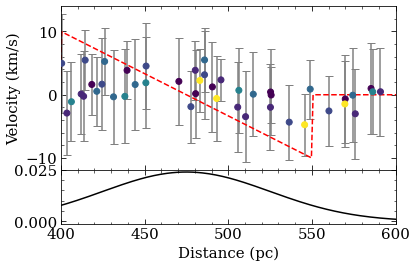

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, sharex = True, gridspec_kw = {'hspace':0, 'height_ratios': (3,1)})
ax = axs[0]
fil = np.nansum(crit_filament)
fil_idx = np.sum(sl_counts[:fil]).astype(int)
start = 0
stop = None
ax.errorbar(d_all[start:stop], v_all[start:stop], yerr = verr_all[start:stop], fmt = '.', capsize = 4, color = 'grey')

points = ax.scatter(d_all[start:stop], v_all[start:stop], c = l_sightline[start:stop], zorder = 5, )

ax.plot(dust_data.distance, rvelo, color = 'r', linestyle = 'dashed')

ax.set_xlim(400, 600)
ax.set_ylabel('Velocity (km/s)')
# fig.colorbar(points, label = 'l (deg)')

ax = axs[1]
ax.plot(dust_data.distance, np.nanmedian(sl_davdd, axis = 0), color = 'k')
ax.set_xlabel('Distance (pc)')
ax.set_xlim(400, 600)



plt.show()

In [ ]:
dist_restrict = (d_all > 400) & (d_all < 550 )
all_spearman = spearmanr(d_all, v_all)
print('ALL:', all_spearman)

restr_spearman = spearmanr(d_all[dist_restrict], v_all[dist_restrict])
print('extent of cloud:', restr_spearman)

ALL: SpearmanrResult(correlation=-0.33755102040816315, pvalue=0.017694914643955357)
extent of cloud: SpearmanrResult(correlation=-0.28803088803088805, pvalue=0.08847295559584702)


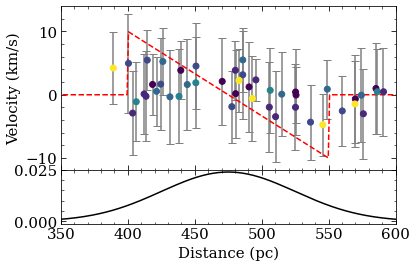

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, sharex = True, gridspec_kw = {'hspace':0, 'height_ratios': (3,1)})
ax = axs[0]
fil = np.nansum(crit_filament)
fil_idx = np.sum(sl_counts[:fil]).astype(int)
start = 0
stop = None
ax.errorbar(d_all[start:stop], v_all[start:stop], yerr = verr_all[start:stop], fmt = '.', capsize = 4, color = 'grey')

points = ax.scatter(d_all[start:stop], v_all[start:stop], c = l_sightline[start:stop], zorder = 5, )

ax.plot(dust_data.distance, rvelo, color = 'r', linestyle = 'dashed')

ax.set_xlim(400, 600)
ax.set_ylabel('Velocity (km/s)')
# fig.colorbar(points, label = 'l (deg)')

ax = axs[1]
ax.plot(dust_data.distance, np.nanmedian(sl_davdd, axis = 0), color = 'k')
ax.set_xlabel('Distance (pc)')
ax.set_xlim(350, 600)



plt.show()

In [ ]:
np.savetxt('spearman' + run_label + '.csv', sl_spearman.astype(float), )